In [3]:
# === Extract PlegmaDataset_Clean.7z ===
import os, glob, subprocess
from pathlib import Path

# Install 7zip
!apt-get -qq update
!apt-get -qq install -y p7zip-full > /dev/null

BASE = Path("/content/plegma_clean")
BASE.mkdir(parents=True, exist_ok=True)
EXTRACT_DIR = BASE / "extracted"
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

ARCHIVE_NAME = "PlegmaDataset_Clean.7z"

# Try to find your uploaded archive
candidates = []
for root in ["/content", "/content/drive/MyDrive", "/workspace", "/root"]:
    candidates += glob.glob(os.path.join(root, "**", ARCHIVE_NAME), recursive=True)

if not candidates:
    raise FileNotFoundError(
        f"Upload {ARCHIVE_NAME} to Colab (left sidebar) and re-run. "
        "If it's in Drive, ensure Drive is mounted at /content/drive."
    )

archive_path = Path(sorted(candidates, key=len)[0])
print("Found archive:", archive_path)

print(f"Extracting -> {EXTRACT_DIR}")
subprocess.run(["7z", "x", str(archive_path), f"-o{EXTRACT_DIR}", "-y"], check=True)

# Peek
print("Top-level:", os.listdir(EXTRACT_DIR)[:8])

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Found archive: /content/PlegmaDataset_Clean.7z
Extracting -> /content/plegma_clean/extracted
Top-level: ['Clean_Dataset']


In [4]:
# === Cell 2 (final fix): Build a PARTITIONED Parquet dataset with a union schema ===
!pip -q install --upgrade pyarrow pandas

import os, re, glob, uuid, json, numpy as np, pandas as pd
from pathlib import Path
import pyarrow as pa, pyarrow.dataset as ds

BASE = Path("/content/plegma_clean")
EXTRACT_DIR = BASE / "extracted"
OUT_DIR = BASE / "parquet_ds"

# Clean rebuild (True = delete and recreate; False = append)
CLEAN_REBUILD = True
if CLEAN_REBUILD and OUT_DIR.exists():
    import shutil
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Collect all CSVs under extracted tree
all_csvs = sorted(glob.glob(str(EXTRACT_DIR / "**" / "*.csv"), recursive=True))
print("CSV files found:", len(all_csvs))

# --- Helpers ---
SKIP_FILENAMES = {"appliances_metadata.csv"}  # skip meta CSVs (no timestamps)
TIME_NAMES = ("timestamp","time","datetime","date","ts")

def find_time_col(cols):
    # 1) exact matches
    lc = [str(c).strip().lower() for c in cols]
    for name in TIME_NAMES:
        if name in lc:
            return cols[lc.index(name)]
    # 2) fuzzy fallback
    for i, c in enumerate(lc):
        if "time" in c or "date" in c:
            return cols[i]
    return None

def infer_house_id(p: str):
    m = re.search(r"[Hh]ouse[_\-\s]?(\d+)", p)
    return int(m.group(1)) if m else None

def should_skip_path(p: str):
    base = os.path.basename(p)
    if base in SKIP_FILENAMES:
        return True
    # skip non-house paths (safety)
    if infer_house_id(p) is None:
        return True
    return False

# --- First pass: build union schema across usable files ---
union_cols = set()
time_col_name = "timestamp"
valid_csvs = []

for p in all_csvs:
    if should_skip_path(p):
        continue
    try:
        head = pd.read_csv(p, nrows=1, low_memory=False)
    except Exception:
        continue
    tcol = find_time_col(head.columns)
    if tcol is None:
        continue
    valid_csvs.append((p, tcol))
    for c in head.columns:
        if c != tcol:
            union_cols.add(str(c))

feature_cols = sorted(union_cols)
target_cols  = [time_col_name] + feature_cols + ["house_id"]

# Arrow schema: timestamp(ns) + all features as float64 + house_id(int16)
fields = [pa.field(time_col_name, pa.timestamp('ns'))]
fields += [pa.field(c, pa.float64()) for c in feature_cols]
fields += [pa.field("house_id", pa.int16())]
target_schema = pa.schema(fields)

print(f"Will write to: {OUT_DIR}")
print(f"Files to process: {len(valid_csvs)} | Feature columns: {len(feature_cols)}")

# Partitioning and write helper
partitioning = ds.partitioning(pa.schema([pa.field("house_id", pa.int16())]), flavor="hive")

# IMPORTANT: set both limits so group <= file to avoid your error
MAX_ROWS_PER_GROUP = 100_000
MAX_ROWS_PER_FILE  = 1_000_000

def write_chunk_df(df: pd.DataFrame, base_dir: Path, hid: int):
    # Ensure all feature columns exist & are numeric
    for c in feature_cols:
        if c not in df.columns:
            df[c] = np.nan
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # Reorder columns strictly to target schema
    df = df[target_cols]

    table = pa.Table.from_pandas(df, schema=target_schema, preserve_index=False)
    ds.write_dataset(
        data=table,
        base_dir=str(base_dir),
        format="parquet",
        partitioning=partitioning,
        schema=target_schema,
        basename_template=f"house{hid}-part-{uuid.uuid4().hex}-{{i}}.parquet",
        existing_data_behavior="overwrite_or_ignore",
        max_rows_per_group=MAX_ROWS_PER_GROUP,  # <= MAX_ROWS_PER_FILE
        max_rows_per_file=MAX_ROWS_PER_FILE
    )

# --- Stream all CSVs in chunks (RAM-safe) ---
CHUNK = 200_000
written_rows = 0
skipped = 0

for p, sniff_tcol in valid_csvs:
    hid = infer_house_id(p)
    try:
        tcol = sniff_tcol  # time column for this file
        for chunk in pd.read_csv(p, chunksize=CHUNK, low_memory=False):
            if tcol not in chunk.columns:
                continue

            # Parse timestamp -> naive ns; drop rows without valid time
            ts = pd.to_datetime(chunk[tcol], errors="coerce", utc=True).dt.tz_convert(None)
            chunk = chunk.assign(**{time_col_name: ts}).dropna(subset=[time_col_name])

            # Add house_id
            chunk["house_id"] = np.int16(hid)

            # Write if anything remains
            if not chunk.empty:
                write_chunk_df(chunk, OUT_DIR, hid)
                written_rows += len(chunk)

    except Exception as e:
        print(f"Skipping {p}: {e}")
        skipped += 1

print(f"Done. Wrote ~{written_rows:,} rows into dataset: {OUT_DIR} | Skipped files: {skipped}")

# --- Quick smoke-check ---
parts = [p for p in OUT_DIR.glob("house_id=*") if p.is_dir()]
print("House partitions:", sorted([int(p.name.split("=")[1]) for p in parts]))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 80.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
CSV files found: 25

In [5]:
# === Loaders for centralized & federated use ===
import numpy as np
import pandas as pd
from pathlib import Path
import pyarrow as pa
import pyarrow.dataset as ds

OUT_DIR = Path("/content/plegma_clean/parquet_ds")

# ---------- internal helpers ----------
def _get_dataset():
    return ds.dataset(OUT_DIR, format="parquet", partitioning="hive")

def _to_ts64ns(x):
    if x is None:
        return None
    t = pd.Timestamp(x)
    if t.tz is not None:
        t = t.tz_convert(None)
    return np.datetime64(t.to_datetime64(), 'ns')

def _build_filter(start=None, end=None, houses=None):
    """Create a pushdown filter for pyarrow.dataset"""
    expr = None
    if houses is not None:
        houses = [int(h) for h in (houses if isinstance(houses, (list, tuple, set)) else [houses])]
        e = ds.field("house_id").isin(houses)
        expr = e if expr is None else (expr & e)

    if start is not None:
        s = _to_ts64ns(start)
        e = ds.field("timestamp") >= s
        expr = e if expr is None else (expr & e)

    if end is not None:
        e_ = _to_ts64ns(end)
        e = ds.field("timestamp") <= e_
        expr = e if expr is None else (expr & e)

    return expr

def list_houses():
    """List available house IDs from partition folders (no full scan)."""
    parts = sorted(int(p.name.split("=")[1]) for p in OUT_DIR.glob("house_id=*") if p.is_dir())
    return parts

def list_columns():
    """Show all columns present in the dataset schema."""
    sch = _get_dataset().schema
    return [f.name for f in sch]

# ---------- public loaders ----------
def load_all(columns=None, start=None, end=None, houses=None, limit=None, sort_time=True):
    """
    Load a pandas DataFrame from the parquet dataset.
      - columns: list[str] to read; None = all columns
      - start/end: datetime-like bounds (e.g. '2023-01-01', pd.Timestamp(...))
      - houses: int or list[int] to restrict to specific houses
      - limit: int to cap the number of rows returned (after filter pushdown)
      - sort_time: sort by 'timestamp' if present
    """
    dataset = _get_dataset()
    filt = _build_filter(start=start, end=end, houses=houses)

    tbl = dataset.to_table(filter=filt, columns=columns)
    if limit is not None and len(tbl) > limit:
        tbl = tbl.slice(0, limit)

    df = tbl.to_pandas()
    if sort_time and "timestamp" in df.columns:
        df = df.sort_values("timestamp", kind="mergesort")  # stable
    return df.reset_index(drop=True)

def load_house(house_id, columns=None, start=None, end=None, limit=None, sort_time=True):
    """Convenience wrapper for a single house."""
    return load_all(columns=columns, start=start, end=end, houses=[house_id],
                    limit=limit, sort_time=sort_time)

# ---------- quick peek / smoke checks ----------
dataset = _get_dataset()
print("Columns (first 25):", dataset.schema.names[:25], "...")
print("Approx total rows:", dataset.count_rows())
print("Houses available:", list_houses())

# sample one house (minimal columns for quick look)
df_h1 = load_house(1, columns=["timestamp","P_agg","house_id"], limit=10_000)
print("House 1 sample rows:", len(df_h1))
print(df_h1.head(3))


Columns (first 25): ['timestamp', 'A', 'P_agg', 'V', 'ac_1', 'ac_2', 'ac_3', 'boiler', 'dishwasher', 'external_humidity', 'external_temparature', 'external_temperature', 'fridge', 'fridge_1', 'fridge_2', 'internal_humidity', 'internal_temperature', 'issues', 'kettle', 'washing_machine', 'house_id'] ...
Approx total rows: 30712034
Houses available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
House 1 sample rows: 10000
            timestamp  P_agg  house_id
0 2022-07-15 00:00:00    NaN         1
1 2022-07-15 00:15:00    NaN         1
2 2022-07-15 00:30:00    NaN         1


In [6]:
# === sliding windows ===
import gc
import numpy as np
import pandas as pd
from pathlib import Path
import pyarrow.dataset as ds

# ---- dataset location ----
OUT_DIR = Path("/content/plegma_clean/parquet_ds")

# ---- minimal loaders ----
def _get_dataset():
    return ds.dataset(OUT_DIR, format="parquet", partitioning="hive")

def list_houses():
    return sorted(int(p.name.split("=")[1]) for p in OUT_DIR.glob("house_id=*") if p.is_dir())

def _to_ts64ns(x):
    if x is None:
        return None
    t = pd.Timestamp(x)
    if t.tz is not None:
        t = t.tz_convert(None)
    return np.datetime64(t.to_datetime64(), "ns")

def load_house(house_id, columns=None, start=None, end=None):
    dataset = _get_dataset()
    flt = (ds.field("house_id") == int(house_id))
    if start is not None:
        flt = flt & (ds.field("timestamp") >= _to_ts64ns(start))
    if end is not None:
        flt = flt & (ds.field("timestamp") <= _to_ts64ns(end))
    tbl = dataset.to_table(filter=flt, columns=columns)
    return tbl.to_pandas()

# ---- windowing utils ----
DEFAULT_FREQ = "10s"
FILL_FAST = 6
FILL_SLOW = 90
DROP_ISSUE_ROWS = True

def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    if "external_temparature" in df.columns and "external_temperature" not in df.columns:
        df = df.rename(columns={"external_temparature": "external_temperature"})
    elif "external_temparature" in df.columns and "external_temperature" in df.columns:
        m = df["external_temperature"].isna()
        df.loc[m, "external_temperature"] = df.loc[m, "external_temparature"]
        df = df.drop(columns=["external_temparature"])
    return df

def regularize_house_timeseries(
    house_id: int,
    target_col: str = "P_agg",
    freq: str = DEFAULT_FREQ,
    fast_fill_limit: int = FILL_FAST,
    slow_fill_limit: int = FILL_SLOW,
    drop_issue_rows: bool = DROP_ISSUE_ROWS,
    columns: list | None = None,
    start=None,
    end=None,
):
    read_cols = columns
    if read_cols is not None:
        read_cols = sorted(set(["timestamp", "house_id", target_col] + list(read_cols)))
    df = load_house(house_id, columns=read_cols, start=start, end=end)
    if df.empty:
        return pd.DataFrame()
    df = _standardize_columns(df)
    if drop_issue_rows and "issues" in df.columns:
        df = df[df["issues"].fillna(0) == 0]
    if "timestamp" not in df.columns:
        return pd.DataFrame()
    df = df.set_index("timestamp").sort_index()
    df = df.resample(freq).mean(numeric_only=True)
    df["house_id"] = np.int16(house_id)
    cols = df.columns.tolist()
    slow_cols = [c for c in cols if ("external_" in c or "internal_" in c)]
    fast_cols = [c for c in cols if c not in slow_cols]
    if fast_cols:
        df[fast_cols] = df[fast_cols].ffill(limit=fast_fill_limit).bfill(limit=fast_fill_limit)
    if slow_cols:
        df[slow_cols] = df[slow_cols].ffill(limit=slow_fill_limit).bfill(limit=slow_fill_limit)
    if target_col not in df.columns:
        return pd.DataFrame()
    df = df[df[target_col].notna()]
    df = df.select_dtypes(include=[np.number])
    for c in df.columns:
        if c != "house_id" and np.issubdtype(df[c].dtype, np.floating):
            df[c] = df[c].astype(np.float32)
    return df

def iter_windows_from_df(
    df: pd.DataFrame,
    input_cols: list | None = None,
    target_col: str = "P_agg",
    lookback: int = 60,
    horizon: int = 1,
    stride: int = 1,
    batch_size: int = 2048,
):
    if df.empty or target_col not in df.columns:
        return
    if input_cols is None:
        input_cols = [c for c in df.columns if c not in (target_col, "house_id")]
    Xmat = df[input_cols].to_numpy(dtype=np.float32, copy=False)
    yvec = df[target_col].to_numpy(dtype=np.float32, copy=False)
    T = len(df)
    if T < lookback + horizon:
        return
    X_batch, y_batch = [], []
    for start in range(0, T - lookback - horizon + 1, stride):
        X_batch.append(Xmat[start : start + lookback])
        y_batch.append(yvec[start + lookback : start + lookback + horizon] if horizon > 1 else yvec[start + lookback])
        if len(X_batch) >= batch_size:
            X = np.asarray(X_batch, dtype=np.float32)
            y = np.asarray(y_batch, dtype=np.float32)
            yield X, y, input_cols
            X_batch.clear(); y_batch.clear(); gc.collect()
    if X_batch:
        X = np.asarray(X_batch, dtype=np.float32)
        y = np.asarray(y_batch, dtype=np.float32)
        yield X, y, input_cols
        X_batch.clear(); y_batch.clear(); gc.collect()

def make_windows_one_house(
    house_id: int,
    target_col: str = "P_agg",
    freq: str = DEFAULT_FREQ,
    lookback: int = 60,
    horizon: int = 1,
    stride: int = 1,
    columns: list | None = None,
    start=None,
    end=None,
    batch_size: int = 2048,
):
    df = regularize_house_timeseries(
        house_id,
        target_col=target_col,
        freq=freq,
        columns=columns,
        start=start,
        end=end,
    )
    if df.empty:
        return
    for X, y, feats in iter_windows_from_df(
        df=df,
        input_cols=None,
        target_col=target_col,
        lookback=lookback,
        horizon=horizon,
        stride=stride,
        batch_size=batch_size,
    ):
        yield X, y, feats, np.full((len(y),), house_id, dtype=np.int16)
    del df; gc.collect()

def iter_centralized_windows(
    houses: list[int] | None = None,
    target_col: str = "P_agg",
    freq: str = DEFAULT_FREQ,
    lookback: int = 60,
    horizon: int = 1,
    stride: int = 1,
    columns: list | None = None,
    start=None,
    end=None,
    batch_size: int = 2048,
):
    if houses is None:
        houses = list_houses()
    used_features = None
    for hid in houses:
        df = regularize_house_timeseries(
            hid, target_col=target_col, freq=freq, columns=columns, start=start, end=end
        )
        if df.empty:
            continue
        if used_features is None:
            used_features = [c for c in df.columns if c not in (target_col, "house_id")]
        else:
            for c in used_features:
                if c not in df.columns:
                    df[c] = np.nan
            extra = [c for c in df.columns if c not in used_features + [target_col, "house_id"]]
            if extra:
                df = df.drop(columns=extra)
            df = df[used_features + [target_col, "house_id"]]
        for X, y, _ in iter_windows_from_df(
            df=df,
            input_cols=used_features,
            target_col=target_col,
            lookback=lookback,
            horizon=horizon,
            stride=stride,
            batch_size=batch_size,
        ):
            yield X, y, used_features, np.full((len(y),), hid, dtype=np.int16)
        del df; gc.collect()

In [7]:
# ---- project-wide calendar split (UTC axis) ----
TRAIN_END = pd.Timestamp("2023-06-30 23:59:59")
VAL_END   = pd.Timestamp("2023-07-31 23:59:59")
TEST_END  = pd.Timestamp("2023-09-30 23:59:59")

# set the local timezone used for date features (adjust if needed)
LOCAL_TZ = "Europe/Athens"   # or set to None to keep UTC; or use tz_offset_hours=5.5 for IST

def house_report(h, target_col="P_agg", freq="10s", columns=None, start=None, end=None):
    df = regularize_house_timeseries(h, target_col=target_col, freq=freq, columns=columns, start=start, end=end)
    if df.empty:
        return {"house": h, "rows": 0}
    info = {
        "house": h,
        "rows": int(len(df)),
        "start": str(df.index.min()),
        "end": str(df.index.max()),
        "cols": list(df.columns),
        "missing_rate": df.isna().mean().sort_values(ascending=False).to_dict(),
        "target_stats": {
            "mean": float(df[target_col].mean()),
            "std": float(df[target_col].std()),
            "p01": float(df[target_col].quantile(0.01)),
            "p99": float(df[target_col].quantile(0.99)),
        }
    }
    del df; gc.collect()
    return info

# ---------- time helpers ----------
def _local_time_index(idx: pd.DatetimeIndex, tz: str | None = None, tz_offset_hours: float | None = None):
    if tz is not None:
        return idx.tz_localize("UTC").tz_convert(tz).tz_localize(None)
    if tz_offset_hours is not None:
        return idx + pd.to_timedelta(tz_offset_hours, unit="h")
    return idx

# ---------- feature engineering (includes date/time features) ----------
def engineer_features(df: pd.DataFrame, tz: str | None = LOCAL_TZ, tz_offset_hours: float | None = None) -> pd.DataFrame:
    if "V" in df.columns and "A" in df.columns:
        S = (df["V"] * df["A"]).astype(np.float32)
        df["apparent_power"] = S
        if "P_agg" in df.columns:
            eps = 1e-6
            df["power_factor"] = (df["P_agg"] / (S + eps)).clip(-1, 1).astype(np.float32)

    if "P_agg" in df.columns:
        df["P_diff_1"] = df["P_agg"].diff(1).astype(np.float32)
        for w in (6, 30, 180):
            r = df["P_agg"].rolling(w, min_periods=1)
            df[f"P_mean_{w}"] = r.mean().astype(np.float32)
            df[f"P_std_{w}"]  = r.std().fillna(0).astype(np.float32)

    if isinstance(df.index, pd.DatetimeIndex):
        lidx = _local_time_index(df.index, tz=tz, tz_offset_hours=tz_offset_hours)

        # second-of-day
        sod = (lidx.view("i8") // 10**9) % 86400
        df["tod_sin"] = np.sin(2*np.pi*sod/86400).astype(np.float32)
        df["tod_cos"] = np.cos(2*np.pi*sod/86400).astype(np.float32)

        # hour-of-day
        hod = lidx.hour.values
        df["hour_sin"] = np.sin(2*np.pi*hod/24).astype(np.float32)
        df["hour_cos"] = np.cos(2*np.pi*hod/24).astype(np.float32)

        # day-of-week
        dow = lidx.dayofweek.values
        df["dow_sin"] = np.sin(2*np.pi*dow/7).astype(np.float32)
        df["dow_cos"] = np.cos(2*np.pi*dow/7).astype(np.float32)
        df["is_weekend"] = (dow >= 5).astype(np.float32)

        # month-of-year
        moy = lidx.month.values - 1
        df["month_sin"] = np.sin(2*np.pi*moy/12).astype(np.float32)
        df["month_cos"] = np.cos(2*np.pi*moy/12).astype(np.float32)

        # week-of-year (ISO)
        iso_week = lidx.isocalendar().week.astype(int).to_numpy() - 1
        df["week_sin"] = np.sin(2*np.pi*iso_week/52).astype(np.float32)
        df["week_cos"] = np.cos(2*np.pi*iso_week/52).astype(np.float32)

    return df

# ---------- robust cleaning + scaling ----------
def quantile_clip(df: pd.DataFrame, cols: list, q_low=0.01, q_high=0.99):
    sub = df.loc[:, cols].astype(np.float32, copy=False)
    ql = sub.quantile(q_low)
    qh = sub.quantile(q_high)
    clipped = sub.clip(lower=ql, upper=qh, axis=1)
    df.loc[:, cols] = clipped.astype(np.float32, copy=False)
    return df

def fit_robust_stats(df: pd.DataFrame, cols: list):
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    med = df[cols].median()
    iqr = (q3 - q1).replace(0, np.nan)
    std = df[cols].std().replace(0, np.nan)
    scale = iqr.fillna(std).replace(0, 1.0)
    return {"median": med.astype(np.float32), "scale": scale.astype(np.float32)}

def apply_robust_scale(df: pd.DataFrame, stats: dict, cols: list):
    med = stats["median"].reindex(cols)
    scale = stats["scale"].reindex(cols).replace(0, 1.0).fillna(1.0)
    df.loc[:, cols] = (
        df.loc[:, cols]
          .sub(med, axis=1)
          .div(scale, axis=1)
          .astype(np.float32)
    )
    return df

def temporal_calendar_split(df: pd.DataFrame):
    tr = df.loc[:TRAIN_END].copy()
    va = df.loc[TRAIN_END + pd.Timedelta(seconds=1) : VAL_END].copy()
    te = df.loc[VAL_END   + pd.Timedelta(seconds=1) : TEST_END].copy()
    return tr, va, te

def time_split(df: pd.DataFrame, train=0.7, val=0.15):
    n = len(df); i1 = int(n*train); i2 = int(n*(train+val))
    return df.iloc[:i1].copy(), df.iloc[i1:i2].copy(), df.iloc[i2:].copy()

In [8]:
# === Full processing pipeline with tqdm (Pass-1 only: global scaler + feature union) ===
import os, gc, json, uuid, inspect
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm

TARGET_COL   = "P_agg"
FREQ         = "10s"
LOOKBACK     = 60
HORIZON      = 1
STRIDE       = 1
BATCH_SIZE   = 4096
HOUSES       = list_houses()

# if you defined TRAIN_END / VAL_END / TEST_END & temporal_calendar_split earlier, we'll use them
USE_CALENDAR_SPLIT = 'temporal_calendar_split' in globals()

# optional: reuse your LOCAL_TZ from earlier; else None
LOCAL_TZ = globals().get("LOCAL_TZ", None)

WORK_DIR   = Path("/content/plegma_clean/ready")
SHARDS_DIR = WORK_DIR / "windows"   # not used yet (Pass-2)
META_DIR   = WORK_DIR / "meta"
WORK_DIR.mkdir(parents=True, exist_ok=True)
SHARDS_DIR.mkdir(parents=True, exist_ok=True)
META_DIR.mkdir(parents=True, exist_ok=True)

BASE_COLS = [
    "P_agg","A","V","ac_1","ac_2","ac_3","boiler","dishwasher","fridge",
    "fridge_1","fridge_2","kettle","washing_machine",
    "internal_temperature","internal_humidity",
    "external_temperature","external_humidity","issues","house_id"
]
ENG_WINDOWS = (6, 30, 180)

# ---- basic FE  ----
def _engineer_features_basic(df: pd.DataFrame) -> pd.DataFrame:
    if "V" in df.columns and "A" in df.columns:
        ap = (df["V"] * df["A"]).astype(np.float32)
        df["apparent_power"] = ap
        if "P_agg" in df.columns:
            S = ap.replace(0, np.nan)
            df["power_factor"] = (df["P_agg"] / S).clip(-1, 1).fillna(0).astype(np.float32)
    if "P_agg" in df.columns:
        df["P_diff_1"] = df["P_agg"].diff(1).astype(np.float32)
        for w in ENG_WINDOWS:
            r = df["P_agg"].rolling(w, min_periods=1)
            df[f"P_mean_{w}"] = r.mean().astype(np.float32)
            df[f"P_std_{w}"]  = r.std().fillna(0).astype(np.float32)
    if isinstance(df.index, pd.DatetimeIndex):
        sod = (df.index.view("i8") // 10**9) % 86400
        df["tod_sin"] = np.sin(2*np.pi*sod/86400).astype(np.float32)
        df["tod_cos"] = np.cos(2*np.pi*sod/86400).astype(np.float32)
        dow = df.index.dayofweek.values
        df["dow_sin"] = np.sin(2*np.pi*dow/7).astype(np.float32)
        df["dow_cos"] = np.cos(2*np.pi*dow/7).astype(np.float32)
        df["is_weekend"] = (dow >= 5).astype(np.float32)
    return df


_engineer_fn = globals().get("engineer_features", _engineer_features_basic)

def _safe_engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    try:
        #  TZ-aware signature
        return _engineer_fn(df, tz=LOCAL_TZ) if "tz" in inspect.signature(_engineer_fn).parameters else _engineer_fn(df)
    except Exception:
        # last resort
        return _engineer_features_basic(df)

def _percent_time_split(df: pd.DataFrame, train=0.7, val=0.15):
    n = len(df); i1 = int(n*train); i2 = int(n*(train+val))
    return df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

def _dedupe_and_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.loc[:, ~df.columns.duplicated()]
    # keep numeric only (plus house_id & target which may already be numeric)
    keep = df.select_dtypes(include=[np.number]).columns.tolist()
    if TARGET_COL in df.columns and TARGET_COL not in keep: keep.append(TARGET_COL)
    if "house_id" in df.columns and "house_id" not in keep: keep.append("house_id")
    df = df[keep]
    # ensure float32 for features, int16 for house_id
    for c in df.columns:
        if c == "house_id":
            df[c] = df[c].astype(np.int16, errors="ignore")
        elif c != TARGET_COL:
            df[c] = df[c].astype(np.float32, copy=False)
    return df

# --- dynamic feature union + TRAIN-only global scaler ---
sums   = defaultdict(float)
sumsq  = defaultdict(float)
counts = defaultdict(int)
feature_union = set()

for hid in tqdm(HOUSES, desc="Pass 1 - compute global scaler (TRAIN only)"):
    df = regularize_house_timeseries(hid, target_col=TARGET_COL, freq=FREQ, columns=BASE_COLS)
    if df.empty:
        continue
    df = _safe_engineer_features(df)
    df = _dedupe_and_numeric(df)

    # choose split mode
    if USE_CALENDAR_SPLIT:
        tr, va, te = temporal_calendar_split(df)
    else:
        tr, va, te = _percent_time_split(df)

    if tr.empty:
        del df, tr, va, te; gc.collect(); continue

    # per-house features = numeric columns except target & house_id
    feats = [c for c in tr.columns if c not in (TARGET_COL, "house_id")]
    feature_union.update(feats)

    # accumulate TRAIN stats
    V = tr[feats].astype(np.float64)  # accumulate in float64 for stability
    sums_local   = V.sum(skipna=True)
    sumsq_local  = (V**2).sum(skipna=True)
    counts_local = V.count()

    for c in feats:
        sums[c]   += float(sums_local[c])
        sumsq[c]  += float(sumsq_local[c])
        counts[c] += int(counts_local[c])

    del df, tr, va, te, V, sums_local, sumsq_local, counts_local
    gc.collect()

FINAL_FEATURES = sorted(feature_union)

# finalize mean/std vectors over the union (missing counts -> 0 mean, unit std)
mean_vals = {}
std_vals  = {}
for c in FINAL_FEATURES:
    if counts[c] > 0:
        m = sums[c] / counts[c]
        v = max((sumsq[c] / counts[c]) - (m*m), 1e-12)
        mean_vals[c] = float(m)
        std_vals[c]  = float(np.sqrt(v))
    else:
        mean_vals[c] = 0.0
        std_vals[c]  = 1.0

mean = pd.Series(mean_vals, dtype=np.float32)
std  = pd.Series(std_vals,  dtype=np.float32)

# save artifacts for Pass-2
(META_DIR / "scaler_mean.json").write_text(json.dumps(mean.to_dict()))
(META_DIR / "scaler_std.json").write_text(json.dumps(std.to_dict()))
(META_DIR / "feature_list.json").write_text(json.dumps(FINAL_FEATURES))
(META_DIR / "config.json").write_text(json.dumps({
    "target": TARGET_COL, "freq": FREQ,
    "lookback": LOOKBACK, "horizon": HORIZON, "stride": STRIDE,
    "batch_size": BATCH_SIZE, "use_calendar_split": USE_CALENDAR_SPLIT,
    "houses": HOUSES
}, indent=2))

print(f"[Pass-1] features={len(FINAL_FEATURES)} | saved scaler + feature_list under {META_DIR}")

# -------- helpers for Pass-2--------
def _standardize_inplace(df: pd.DataFrame, feats):
    """Apply global (TRAIN-derived) mean/std to df[feats] in-place."""
    m = mean.reindex(feats).fillna(0.0).to_numpy(dtype=np.float32)
    s = std.reindex(feats).replace(0, 1.0).fillna(1.0).to_numpy(dtype=np.float32)
    X = df[feats].to_numpy(dtype=np.float32, copy=False)
    X -= m
    X /= s
    df.loc[:, feats] = X
    return df

def _iter_windows_matrix(M: np.ndarray, y: np.ndarray, lookback, horizon, stride, batch_size):
    """Window maker for Pass-2 (not called here)."""
    T = len(y)
    if T < lookback + horizon:
        return
    Xb, yb = [], []
    for s0 in range(0, T - lookback - horizon + 1, stride):
        Xb.append(M[s0:s0+lookback])
        yb.append(y[s0+lookback:s0+lookback+horizon] if horizon>1 else y[s0+lookback])
        if len(Xb) >= batch_size:
            yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32)
            Xb.clear(); yb.clear(); gc.collect()
    if Xb:
        yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32)
        Xb.clear(); yb.clear(); gc.collect()

def _write_shards(df: pd.DataFrame, split: str, hid: int, features,
                  lookback=LOOKBACK, horizon=HORIZON, stride=STRIDE, batch_size=BATCH_SIZE):
    """Shard writer for Pass-2 (not called in Pass-1)."""
    outdir = SHARDS_DIR / f"house_id={hid}" / split
    outdir.mkdir(parents=True, exist_ok=True)
    M = df[features].to_numpy(dtype=np.float32, copy=False)
    y = df[TARGET_COL].to_numpy(dtype=np.float32, copy=False)
    shard_idx = 0; total = 0
    for Xb, yb in _iter_windows_matrix(M, y, lookback, horizon, stride, batch_size):
        shard_idx += 1; total += len(yb)
        fname = outdir / f"part-{shard_idx:05d}-{uuid.uuid4().hex}.npz"
        np.savez_compressed(fname, X=Xb, y=yb, features=np.array(features), target=np.array([TARGET_COL]))
        del Xb, yb; gc.collect()
    return total


Pass 1 - compute global scaler (TRAIN only):   0%|          | 0/13 [00:00<?, ?it/s]

[Pass-1] features=37 | saved scaler + feature_list under /content/plegma_clean/ready/meta


In [9]:
# === Inspection + preprocessing + feature engineering + ready-for-windows (RAM-light, TZ-aware) ===
import gc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# === Inspection + preprocessing + feature engineering + ready-for-windows (RAM-light, TZ-aware) ===
import gc
import numpy as np
import pandas as pd

def _fallback_time_split(df: pd.DataFrame, train=0.7, val=0.15):
    n = len(df); i1 = int(n * train); i2 = int(n * (train + val))
    return df.iloc[:i1].copy(), df.iloc[i1:i2].copy(), df.iloc[i2:].copy()

def prepare_house(
    h,
    target_col: str = "P_agg",
    freq: str = "10s",
    q_clip=(0.01, 0.99),
    columns=None,
    start=None,
    end=None,
    tz: str | None = None,                 # safe default; adopts LOCAL_TZ if present
    tz_offset_hours: float | None = None,
    split_by_calendar: bool = True,
    features: list | None = None           # optional: force a specific feature set/order
):
    # adopt global LOCAL_TZ if not provided
    if tz is None and "LOCAL_TZ" in globals():
        tz = LOCAL_TZ

    df = regularize_house_timeseries(
        h, target_col=target_col, freq=freq, columns=columns, start=start, end=end
    )
    if df.empty:
        return None

    # feature engineering (tz-aware if supported)
    try:
        df = engineer_features(df, tz=tz, tz_offset_hours=tz_offset_hours)
    except TypeError:
        df = engineer_features(df)

    # ensure a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        if "timestamp" in df.columns:
            df = df.set_index("timestamp").sort_index()
        else:
            df = df.sort_index()

    # build feature list
    if features is None:
        feat_cols = [
            c for c in df.columns
            if c not in (target_col, "house_id", "issues")
            and pd.api.types.is_numeric_dtype(df[c])
        ]
    else:
        feat_cols = list(features)
        for c in feat_cols:
            if c not in df.columns:
                df[c] = np.nan

    # dtypes
    if "house_id" in df.columns:
        df["house_id"] = df["house_id"].astype(np.int16, errors="ignore")
    if target_col in df.columns:
        df[target_col] = df[target_col].astype(np.float32, copy=False)
    for c in feat_cols:
        df[c] = df[c].astype(np.float32, copy=False)

    # ---- quantile CLIP in float32 (no pandas upcast) ----
    if q_clip is not None and len(feat_cols) > 0:
        ql = df[feat_cols].quantile(q_clip[0]).reindex(feat_cols)
        qh = df[feat_cols].quantile(q_clip[1]).reindex(feat_cols)
        lower = ql.to_numpy(dtype=np.float32)
        upper = qh.to_numpy(dtype=np.float32)
        # if a col has all-NaN quantiles, don't constrain it
        lower = np.where(np.isnan(lower), -np.inf, lower)
        upper = np.where(np.isnan(upper),  +np.inf, upper)
        X = df[feat_cols].to_numpy(dtype=np.float32, copy=False)
        np.clip(X, lower, upper, out=X)           # per-column clip
        df.loc[:, feat_cols] = X

    # clean infinities (features only)
    if len(feat_cols) > 0:
        df.loc[:, feat_cols] = df[feat_cols].replace([np.inf, -np.inf], np.nan).astype(np.float32)

    # split
    if split_by_calendar and "temporal_calendar_split" in globals():
        tr, va, te = temporal_calendar_split(df)
    elif "time_split" in globals():
        tr, va, te = time_split(df)
    else:
        tr, va, te = _fallback_time_split(df)

    if tr is None or tr.empty:
        return None

    # no-feature case
    if len(feat_cols) == 0:
        stats = {"median": pd.Series(dtype=np.float32), "scale": pd.Series(dtype=np.float32)}
        return {"train": tr, "val": va, "test": te, "features": feat_cols, "stats": stats}

    # ---- robust stats on TRAIN ----
    q1 = tr[feat_cols].quantile(0.25)
    q3 = tr[feat_cols].quantile(0.75)
    med = tr[feat_cols].median()
    iqr = (q3 - q1).replace(0, np.nan)
    std = tr[feat_cols].std().replace(0, np.nan)
    scale = iqr.fillna(std).replace(0, 1.0).astype(np.float32)
    stats = {"median": med.astype(np.float32), "scale": scale}

    # ---- SCALE each split in float32 arrays (no upcasts) ----
    splits = {"train": tr, "val": va, "test": te}
    m = stats["median"].reindex(feat_cols).to_numpy(dtype=np.float32)
    s = stats["scale"].reindex(feat_cols).replace(0, 1.0).to_numpy(dtype=np.float32)

    for name, sdf in list(splits.items()):
        if sdf is None or sdf.empty:
            continue
        for c in feat_cols:
            if c not in sdf.columns:
                sdf[c] = np.nan
        order = feat_cols + [target_col] + (["house_id"] if "house_id" in sdf.columns else [])
        sdf = sdf.reindex(columns=order)

        X = sdf[feat_cols].to_numpy(dtype=np.float32, copy=False)
        X -= m
        X /= s
        mask = ~np.isfinite(X)
        if mask.any():
            X[mask] = 0.0
        sdf.loc[:, feat_cols] = X
        splits[name] = sdf

    return {
        "train": splits["train"],
        "val": splits["val"],
        "test": splits["test"],
        "features": feat_cols,
        "stats": stats,
    }

def iter_windows_from_processed(
    split_df: pd.DataFrame,
    target_col: str = "P_agg",
    lookback: int = 60,
    horizon: int = 1,
    stride: int = 1,
    batch_size: int = 2048,
    features: list | None = None
):
    if split_df is None or split_df.empty:
        return

    if features is None:
        feats = [
            c for c in split_df.columns
            if c not in (target_col, "house_id", "issues")
            and pd.api.types.is_numeric_dtype(split_df[c])
        ]
    else:
        feats = list(features)
        miss = [c for c in feats if c not in split_df.columns]
        if miss:
            split_df = split_df.copy()
            for c in miss:
                split_df[c] = np.nan

    if len(feats) == 0 or target_col not in split_df.columns:
        return

    split_df = split_df.copy()
    # keep features strictly float32 to avoid implicit upcasts
    split_df.loc[:, feats] = (
        split_df[feats]
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
        .astype(np.float32)
    )

    Xmat = split_df[feats].to_numpy(dtype=np.float32, copy=False)
    yvec = split_df[target_col].to_numpy(dtype=np.float32, copy=False)
    T = len(split_df)
    if T < lookback + horizon:
        return

    Xb, yb = [], []
    for s in range(0, T - lookback - horizon + 1, stride):
        Xb.append(Xmat[s:s + lookback])
        yb.append(yvec[s + lookback:s + lookback + horizon] if horizon > 1 else yvec[s + lookback])
        if len(Xb) >= batch_size:
            yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32), feats
            Xb.clear(); yb.clear(); gc.collect()
    if Xb:
        yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32), feats
        Xb.clear(); yb.clear(); gc.collect()


# ---------- usage (per-house) ----------
h = 1
prep = prepare_house(
    h, target_col="P_agg", freq="10s",
    tz=globals().get("LOCAL_TZ", None),     # None to keep UTC; or use tz_offset_hours for fixed offsets
    split_by_calendar=True,
    columns=[
        "P_agg","A","V","ac_1","ac_2","ac_3","boiler","dishwasher","fridge","fridge_1","fridge_2",
        "kettle","washing_machine","internal_temperature","internal_humidity",
        "external_temperature","external_humidity","issues","house_id"
    ],
    # features=None  # or pass your Pass-1 union features list to lock order across houses
)

if 'house_report' in globals():
    print(house_report(h))

if prep is not None:
    for Xb, yb, feats in iter_windows_from_processed(prep["train"], target_col="P_agg", lookback=60, horizon=1, batch_size=1024, features=prep["features"]):
        print("train batch:", Xb.shape, yb.shape, len(feats)); break
    for Xb, yb, feats in iter_windows_from_processed(prep["val"], target_col="P_agg", lookback=60, horizon=1, batch_size=1024, features=prep["features"]):
        print("val batch:", Xb.shape, yb.shape, len(feats)); break
    for Xb, yb, feats in iter_windows_from_processed(prep["test"], target_col="P_agg", lookback=60, horizon=1, batch_size=1024, features=prep["features"]):
        print("test batch:", Xb.shape, yb.shape, len(feats)); break
else:
    print(f"House {h} returned no data after regularization.")


{'house': 1, 'rows': 3796169, 'start': '2022-07-15 00:00:00', 'end': '2023-09-30 23:59:50', 'cols': ['A', 'P_agg', 'V', 'ac_1', 'ac_2', 'ac_3', 'boiler', 'dishwasher', 'external_humidity', 'external_temperature', 'fridge', 'fridge_1', 'fridge_2', 'internal_humidity', 'internal_temperature', 'issues', 'kettle', 'washing_machine', 'house_id'], 'missing_rate': {'fridge_2': 1.0, 'dishwasher': 1.0, 'ac_3': 1.0, 'kettle': 1.0, 'fridge_1': 1.0, 'internal_humidity': 0.10254100910681269, 'internal_temperature': 0.10251940838250352, 'ac_2': 0.05430079640816834, 'fridge': 0.019029711269440322, 'washing_machine': 0.0071205997414762095, 'boiler': 0.004750842230680457, 'ac_1': 0.0018629307599319208, 'A': 1.9493336571685823e-05, 'V': 7.3758570811784195e-06, 'external_temperature': 1.3171173359247179e-06, 'external_humidity': 1.3171173359247179e-06, 'P_agg': 0.0, 'issues': 0.0, 'house_id': 0.0}, 'target_stats': {'mean': 325.9812927246094, 'std': 732.3603515625, 'p01': 24.799999237060547, 'p99': 4243.1

In [10]:
# === Research EDA across ALL houses: energy requirements + uncertainty-aware views ===
# Uses: list_houses(), regularize_house_timeseries()
# Produces a per-house summary DataFrame (add plots afterward if you like)

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- config ----------------
FREQ_RAW   = "10s"
FREQ_EDA   = "1min"
LOCAL_TZ   = "Europe/Athens"   # set None to keep UTC
TARGET_COL = "P_agg"

EDA_COLS = [
    "P_agg","A","V","ac_1","ac_2","ac_3","boiler","dishwasher","fridge","fridge_1","fridge_2",
    "kettle","washing_machine","internal_temperature","internal_humidity",
    "external_temperature","external_humidity","issues","house_id"
]
APPLIANCE_COLS = ["ac_1","ac_2","ac_3","boiler","dishwasher","fridge","fridge_1","fridge_2","kettle","washing_machine"]

# ---------------- helpers ----------------
def _local_index(idx: pd.DatetimeIndex, tz=LOCAL_TZ):
    """Convert UTC (naive or aware) index to local tz, then drop tz to keep everything naive."""
    if tz is None:
        return idx
    if idx.tz is None:
        idx = idx.tz_localize("UTC")
    return idx.tz_convert(tz).tz_localize(None)

def _energy_kwh_from_series(power_w: pd.Series, step_seconds: int) -> float:
    # Energy (kWh) = sum(W) * dt(s) / 3600 / 1000
    return float(power_w.fillna(0).sum() * (step_seconds / 3600.0) / 1000.0)

def _autocorr(x: np.ndarray, max_lag: int) -> np.ndarray:
    x = x.astype(np.float64)
    mu = np.nanmean(x)
    x = np.where(np.isnan(x), 0.0, x - mu)
    n = len(x)
    denom = np.dot(x, x)
    if denom == 0:
        return np.zeros(max_lag + 1, dtype=np.float64)
    acf = np.empty(max_lag + 1, dtype=np.float64)
    for k in range(max_lag + 1):
        acf[k] = np.dot(x[:n-k], x[k:]) / denom
    return acf

def _minute_house_df(house_id: int) -> pd.DataFrame:
    df_raw = regularize_house_timeseries(house_id, target_col=TARGET_COL, freq=FREQ_RAW, columns=EDA_COLS)
    if df_raw.empty:
        return df_raw
    if "apparent_power" not in df_raw.columns and {"A","V"}.issubset(df_raw.columns):
        df_raw = df_raw.copy()
        df_raw["apparent_power"] = (df_raw["A"] * df_raw["V"]).astype(np.float32)
    df = df_raw.resample(FREQ_EDA).mean(numeric_only=True)
    df.index.name = "timestamp"
    return df

def _variability_index(df_minute: pd.DataFrame, target="P_agg", idx_local=None) -> float:
    # Median IQR across hours (variation from day-to-day at each hour)
    if idx_local is None:
        idx_local = _local_index(df_minute.index)
    d = pd.DataFrame({target: df_minute[target].values}, index=idx_local)
    g = d.groupby([d.index.date, d.index.hour])[target].mean().unstack()
    if g is None or g.empty:
        return float("nan")
    iqr_per_hour = g.quantile(0.75) - g.quantile(0.25)
    return float(np.nanmedian(iqr_per_hour.values))

def _temp_slope(df_minute: pd.DataFrame) -> float:
    # simple linear slope (W per °C), requires enough overlap
    if "external_temperature" not in df_minute.columns:
        return float("nan")
    x = df_minute["external_temperature"].to_numpy(dtype=float)
    y = df_minute["P_agg"].to_numpy(dtype=float)
    m = ~np.isnan(x) & ~np.isnan(y)
    if m.sum() < 1000:
        return float("nan")
    slope = np.polyfit(x[m], y[m], 1)[0]
    return float(slope)

def _calc_daily_kwh(df_minute: pd.DataFrame, idx_local=None) -> pd.Series:
    if idx_local is None:
        idx_local = _local_index(df_minute.index)
    return df_minute["P_agg"].groupby(pd.Index(idx_local.date, name="date")).apply(
        lambda s: _energy_kwh_from_series(s, step_seconds=60)
    )

def _appliance_energy_share(df_minute: pd.DataFrame) -> dict:
    # returns per-appliance total kWh over the available period
    shares = {}
    for c in [c for c in APPLIANCE_COLS if c in df_minute.columns]:
        shares[c] = _energy_kwh_from_series(df_minute[c], step_seconds=60)
    return shares

# ---------------- compute per-house summaries ----------------
houses = list_houses()
summ_rows = []
daily_kwh_by_house = {}
appliance_totals_by_house = {}

for hid in houses:
    df = _minute_house_df(hid)
    if df.empty:
        summ_rows.append({
            "house_id": hid, "start": None, "end": None, "minutes": 0,
            "baseload_w": np.nan, "peak_w": np.nan,
            "mean_daily_kwh": np.nan, "p95_daily_kwh": np.nan,
            "temp_corr": np.nan, "temp_slope_w_per_c": np.nan,
            "variability_index": np.nan
        })
        continue

    lidx = _local_index(df.index)

    # daily energy
    daily_kwh = _calc_daily_kwh(df, lidx)
    daily_kwh_by_house[hid] = daily_kwh

    # baseload/peak (robust quantiles)
    pa = df["P_agg"].to_numpy(dtype=float)
    baseload_w = float(np.nanpercentile(pa, 5))
    peak_w     = float(np.nanpercentile(pa, 99))

    # temperature correlation & slope
    if "external_temperature" in df.columns:
        temp_corr = float(df["P_agg"].corr(df["external_temperature"]))  # pairwise NA drop
    else:
        temp_corr = float("nan")
    temp_slope = _temp_slope(df)

    # variability index (median IQR across hours)
    var_idx = _variability_index(df, target="P_agg", idx_local=lidx)

    # appliance energy
    app_shares = _appliance_energy_share(df)
    appliance_totals_by_house[hid] = app_shares

    summ_rows.append({
        "house_id": hid,
        "start": str(lidx.min()),
        "end": str(lidx.max()),
        "minutes": int(len(df)),
        "baseload_w": baseload_w,
        "peak_w": peak_w,
        "mean_daily_kwh": float(daily_kwh.mean()) if len(daily_kwh) > 0 else np.nan,
        "p95_daily_kwh": float(np.nanpercentile(daily_kwh.values, 95)) if len(daily_kwh) > 0 else np.nan,
        "temp_corr": temp_corr,
        "temp_slope_w_per_c": temp_slope,
        "variability_index": var_idx
    })

    del df; gc.collect()

summary = pd.DataFrame(summ_rows).sort_values("house_id").reset_index(drop=True)
summary


,house_id,start,end,minutes,baseload_w,peak_w,mean_daily_kwh,p95_daily_kwh,temp_corr,temp_slope_w_per_c,variability_index
0,1,2022-07-15 03:00:00,2023-10-01 02:59:00,637920,25.493166,4241.645190,7.770391,22.548812,0.270167,28.526512,101.111412
1,2,2022-09-17 03:00:00,2023-03-26 21:10:00,274691,24.670832,4013.124854,7.275651,23.791123,-0.198131,-29.717902,135.952789
2,3,2022-07-11 15:45:00,2023-10-01 02:59:00,642915,39.608166,3636.460010,6.385371,13.447848,-0.015456,-1.358556,38.126579
3,4,2022-10-10 17:02:00,2023-10-01 02:59:00,511798,45.875271,3624.384082,7.882403,20.323843,-0.110180,-10.395647,112.281067
4,5,2023-01-01 02:00:00,2023-10-01 02:59:00,393120,44.659201,4093.438037,13.008809,20.778678,0.043587,7.803555,589.867859
5,6,2023-03-01 02:00:00,2023-10-01 02:59:00,308160,14.301666,4439.509878,6.508646,13.670496,0.128582,16.207060,153.365662
6,7,2022-11-01 02:00:00,2023-10-01 02:59:00,480960,48.577365,3588.364990,6.107210,16.492681,-0.127684,-9.200355,62.760830
7,8,2023-03-01 02:00:00,2023-10-01 02:59:00,308160,20.478333,2206.545176,5.675413,11.658486,0.347009,28.649134,308.697327
8,9,2023-02-01 02:00:00,2023-10-01 02:59:00,348480,9.533500,3758.710388,4.948645,12.434958,0.083077,5.741667,115.024490
9,10,2023-04-21 11:02:00,2023-10-01 02:59:00,234238,43.232074,3137.431243,8.647419,27.068066,0.281344,31.730153,231.120575


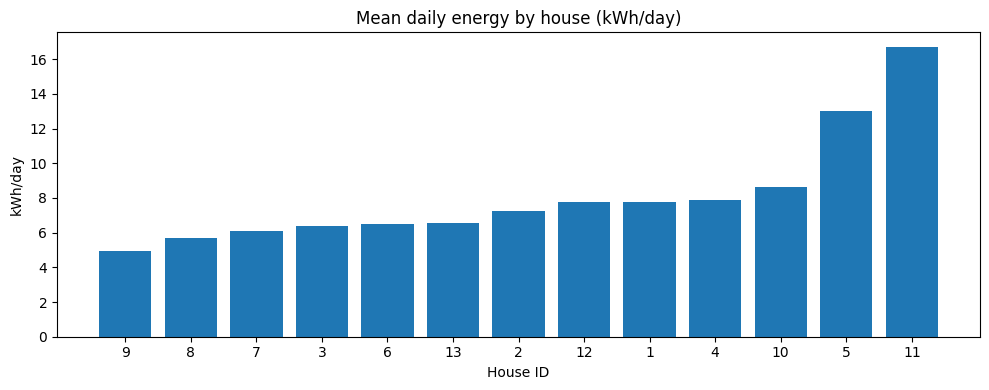

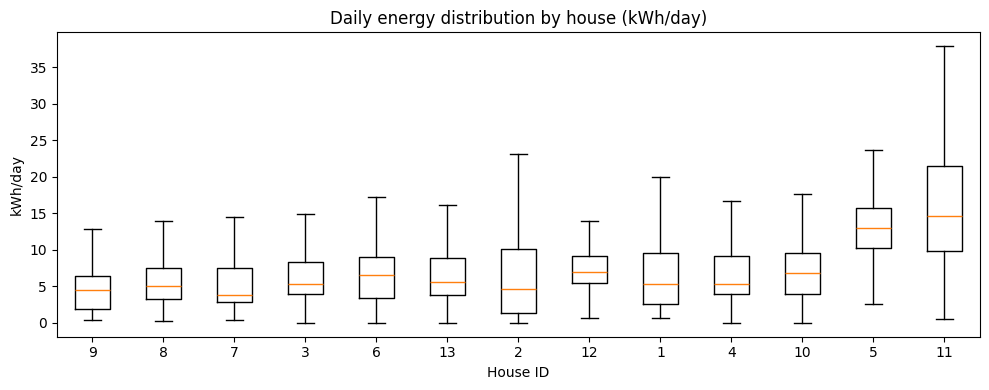

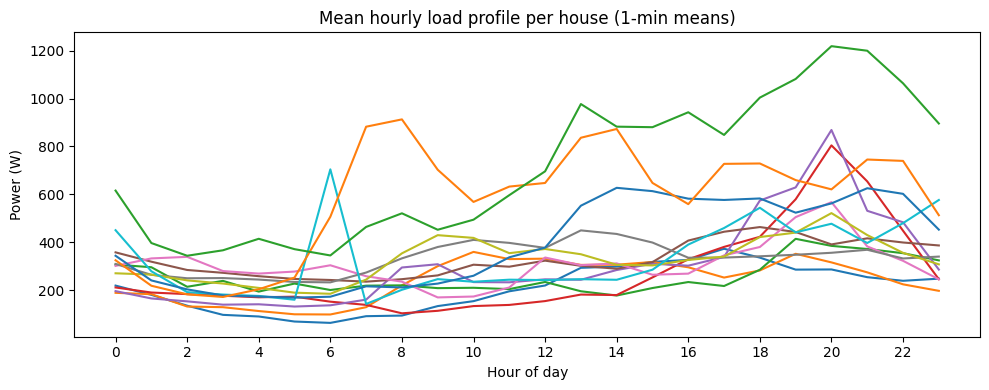

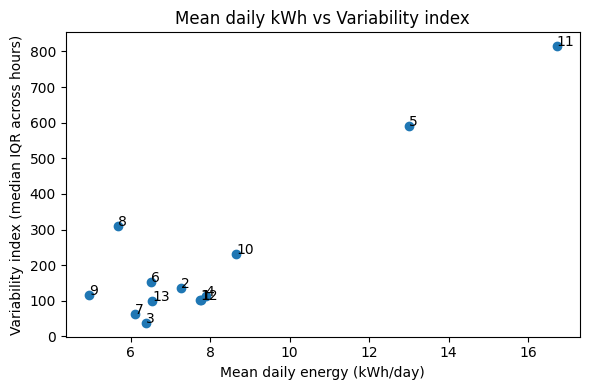

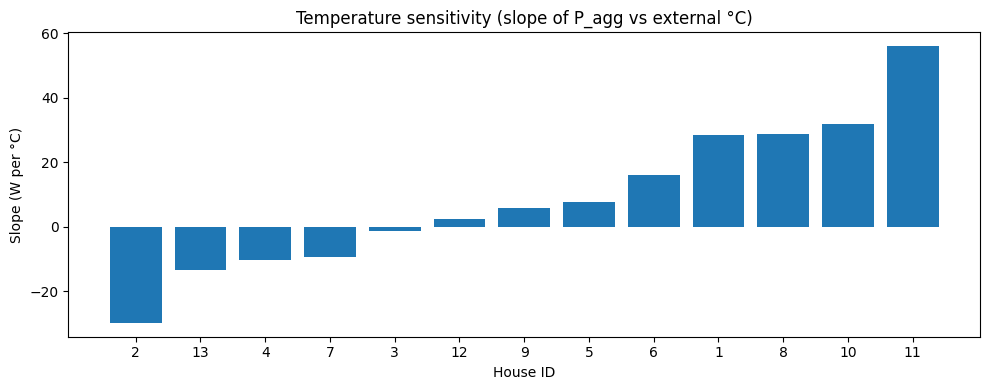

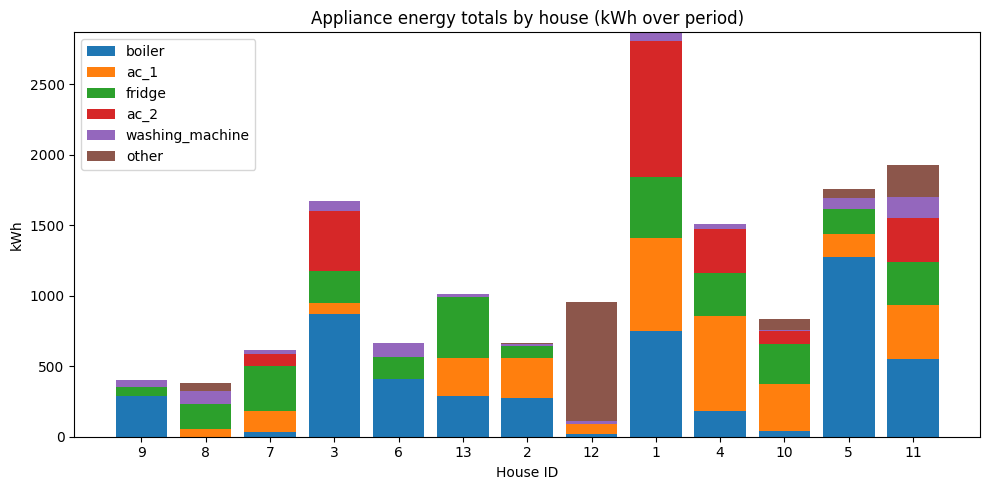

EDA complete 


In [11]:
# --- PLOTS (Matplotlib only; one chart per figure) ---
import functools

# cache to avoid recomputing per house
@functools.lru_cache(maxsize=None)
def _minute_house_df_cached(hid: int):
    return _minute_house_df(hid)

#  quick guards
if summary is None or summary.empty:
    print("EDA: summary is empty — nothing to plot yet.")
else:
    # Mean daily kWh per house
    valid = summary.dropna(subset=["mean_daily_kwh"])
    if len(valid) > 0:
        order = valid.sort_values("mean_daily_kwh")["house_id"].values
        vals  = valid.set_index("house_id").loc[order, "mean_daily_kwh"].values

        plt.figure(figsize=(10,4))
        plt.bar(range(len(order)), vals)
        plt.xticks(range(len(order)), order)
        plt.title("Mean daily energy by house (kWh/day)")
        plt.xlabel("House ID"); plt.ylabel("kWh/day")
        plt.tight_layout(); plt.show()
    else:
        print("Plot 1: No houses with mean_daily_kwh.")

    #  Boxplot: distribution of daily kWh per house (filter empty)
    if 'order' in locals():
        data = []
        labels = []
        for hid in order:
            s = daily_kwh_by_house.get(hid, pd.Series(dtype=float))
            if s is not None and len(s) > 0:
                data.append(s.values)
                labels.append(hid)
        if len(data) > 0:
            plt.figure(figsize=(10,4))
            plt.boxplot(data, showfliers=False)
            plt.xticks(range(1, len(labels)+1), labels)
            plt.title("Daily energy distribution by house (kWh/day)")
            plt.xlabel("House ID"); plt.ylabel("kWh/day")
            plt.tight_layout(); plt.show()
        else:
            print("Plot 2: No daily-kWh samples to boxplot.")

    # Overlay: mean hour-of-day profile (local) per house
    if 'order' in locals() and len(order) > 0:
        plt.figure(figsize=(10,4))
        for hid in order:
            d = _minute_house_df_cached(hid)
            if d is None or d.empty or TARGET_COL not in d.columns:
                continue
            lidx = _local_index(d.index)
            hod = pd.Index(lidx.hour, name="hour")
            prof = d[TARGET_COL].groupby(hod).mean()
            if len(prof) > 0:
                plt.plot(prof.index, prof.values, label=f"H{hid}")
        plt.title("Mean hourly load profile per house (1-min means)")
        plt.xlabel("Hour of day"); plt.ylabel("Power (W)")
        plt.xticks(range(0,24,2))
        plt.tight_layout(); plt.show()
    else:
        print("Plot 3: No houses to overlay.")

    # Scatter: mean daily kWh vs variability index
    m = valid.dropna(subset=["variability_index"])
    if len(m) > 0:
        x = m["mean_daily_kwh"].values
        y = m["variability_index"].values
        plt.figure(figsize=(6,4))
        plt.scatter(x, y)
        for i, hid in enumerate(m["house_id"].values):
            plt.annotate(str(hid), (x[i], y[i]))
        plt.title("Mean daily kWh vs Variability index")
        plt.xlabel("Mean daily energy (kWh/day)")
        plt.ylabel("Variability index (median IQR across hours)")
        plt.tight_layout(); plt.show()
    else:
        print("Plot 4: No (mean_daily_kwh, variability) pairs to scatter.")

    # Temperature sensitivity (slope W/°C)
    temp_ok = valid.dropna(subset=["temp_slope_w_per_c"])
    if len(temp_ok) > 0:
        order_t = temp_ok.sort_values("temp_slope_w_per_c")["house_id"].values
        vals_t  = temp_ok.set_index("house_id").loc[order_t, "temp_slope_w_per_c"].values
        plt.figure(figsize=(10,4))
        plt.bar(range(len(order_t)), vals_t)
        plt.xticks(range(len(order_t)), order_t)
        plt.title("Temperature sensitivity (slope of P_agg vs external °C)")
        plt.xlabel("House ID"); plt.ylabel("Slope (W per °C)")
        plt.tight_layout(); plt.show()
    else:
        print("Plot 5: No temperature slopes available.")

    # Stacked bars: appliance energy (choose totals or % shares)
    # Currently totals (kWh).
    NORMALIZE = False

    global_app_totals = {}
    for hid, d in appliance_totals_by_house.items():
        for k, v in (d or {}).items():
            global_app_totals[k] = global_app_totals.get(k, 0.0) + (v or 0.0)

    if global_app_totals:
        top5 = [k for k,_ in sorted(global_app_totals.items(), key=lambda kv: kv[1], reverse=True)[:5]]
        houses_for_stack = [h for h in (order if 'order' in locals() else list(appliance_totals_by_house.keys()))
                            if h in appliance_totals_by_house]
        stacks = {k: [] for k in top5}
        other = []
        for hid in houses_for_stack:
            ap = appliance_totals_by_house.get(hid, {})
            total = sum(ap.values()) if ap else 0.0
            subtot = 0.0
            vals_k = []
            for k in top5:
                val = float(ap.get(k, 0.0))
                vals_k.append(val)
                subtot += val
            rest = max(total - subtot, 0.0)

            if NORMALIZE and total > 0:
                vals_k = [v/total for v in vals_k]
                rest   = rest/total

            for k, v in zip(top5, vals_k):
                stacks[k].append(v)
            other.append(rest)

        plt.figure(figsize=(10,5))
        bottom = np.zeros(len(houses_for_stack), dtype=float)
        for k in top5:
            vals_k = np.array(stacks[k], dtype=float)
            plt.bar(range(len(houses_for_stack)), vals_k, bottom=bottom, label=k)
            bottom = bottom + vals_k
        plt.bar(range(len(houses_for_stack)), other, bottom=bottom, label=("other" if not NORMALIZE else "other (%)"))
        plt.xticks(range(len(houses_for_stack)), houses_for_stack)
        plt.title("Appliance energy totals by house (kWh over period)" if not NORMALIZE
                  else "Appliance energy shares by house (%)")
        plt.xlabel("House ID"); plt.ylabel("kWh" if not NORMALIZE else "Share")
        plt.legend()
        plt.tight_layout(); plt.show()
    else:
        print("Plot 6: No appliance totals to stack.")

    print("EDA complete ")


In [12]:
# === Final centralized dataset with per-house energy totals (kWh) ===
import gc, json, uuid
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# --------- calendar split (UTC) & IO ---------
TRAIN_END = pd.Timestamp("2023-06-30 23:59:59")
VAL_END   = pd.Timestamp("2023-07-31 23:59:59")
TEST_END  = pd.Timestamp("2023-09-30 23:59:59")

WORK_DIR   = Path("/content/plegma_final")
SHARDS_DIR = WORK_DIR / "windows"
META_DIR   = WORK_DIR / "meta"
for d in (WORK_DIR, SHARDS_DIR, META_DIR): d.mkdir(parents=True, exist_ok=True)

# --------- windowing/storage params ---------
LOOKBACK      = 60
HORIZON       = 1
STRIDE        = 1
SHARD_WINDOWS = 2048
STORE_X_DTYPE = np.float16
STORE_Y_DTYPE = np.float32
COMPRESS_NPZ  = True

# --------- base columns ---------
BASE_COLS = [
    "P_agg","A","V","ac_1","ac_2","ac_3","boiler","dishwasher",
    "fridge","fridge_1","fridge_2","kettle","washing_machine",
    "internal_temperature","internal_humidity",
    "external_temperature","external_humidity","issues","house_id"
]

# --------- engineered features (must match your engineer_features()) ---------
ENG_WINDOWS = (6, 30, 180)
DATE_COLS   = ["tod_sin","tod_cos","hour_sin","hour_cos","dow_sin","dow_cos",
               "is_weekend","month_sin","month_cos","week_sin","week_cos"]
ENG_COLS    = (["apparent_power","power_factor","P_diff_1"]
               + [f"P_mean_{w}" for w in ENG_WINDOWS]
               + [f"P_std_{w}"  for w in ENG_WINDOWS]
               + DATE_COLS)

CANDIDATE_FEATURES = [
    "A","V","ac_1","ac_2","ac_3","boiler","dishwasher",
    "fridge","fridge_1","fridge_2","kettle","washing_machine",
    "internal_temperature","internal_humidity",
    "external_temperature","external_humidity",
] + ENG_COLS

TARGET_COL  = "P_agg"
ENGINEER_TZ = globals().get("LOCAL_TZ", None)  # e.g., "Europe/Athens"
STEP_SECONDS = 10.0                            # regularize_house_timeseries(..., freq="10s")

# --------- utilities ---------
def temporal_calendar_split(df: pd.DataFrame):
    tr = df.loc[:TRAIN_END].copy()
    va = df.loc[TRAIN_END + pd.Timedelta(seconds=1) : VAL_END].copy()
    te = df.loc[VAL_END   + pd.Timedelta(seconds=1) : TEST_END].copy()
    return tr, va, te

def quantile_clip_np_df(df: pd.DataFrame, cols: list, q_low=0.01, q_high=0.99):
    if not cols: return df
    ql = df[cols].quantile(q_low).reindex(cols)
    qh = df[cols].quantile(q_high).reindex(cols)
    lower = np.where(np.isnan(ql.values.astype(np.float32)), -np.inf, ql.values.astype(np.float32))
    upper = np.where(np.isnan(qh.values.astype(np.float32)),  +np.inf, qh.values.astype(np.float32))
    X = df.loc[:, cols].to_numpy(dtype=np.float32, copy=False)
    np.clip(X, lower, upper, out=X)
    df.loc[:, cols] = X
    return df

def _local_index(idx: pd.DatetimeIndex, tz=ENGINEER_TZ):
    if tz is None:
        return idx
    return idx.tz_localize("UTC").tz_convert(tz).tz_localize(None)

def _energy_kwh_from_series(power_w: pd.Series, step_seconds=STEP_SECONDS) -> float:
    v = power_w.astype(np.float64).to_numpy(copy=False)
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    return float(v.sum() * (step_seconds / 3600.0) / 1000.0)

def _daily_kwh(df: pd.DataFrame) -> pd.Series:
    """Daily kWh by local day boundaries from a dataframe containing TARGET_COL at 10s."""
    if df.empty or TARGET_COL not in df.columns:
        return pd.Series(dtype=float)
    lidx = _local_index(df.index)
    s = pd.Series(df[TARGET_COL].values, index=lidx, dtype=np.float32)
    g = s.groupby(s.index.date)
    out = g.apply(lambda x: _energy_kwh_from_series(x, step_seconds=STEP_SECONDS))
    out.index = pd.to_datetime(out.index)  # nice for CSV/plotting
    return out

# --------- feature selection (coverage-based) ---------
houses = list_houses()
coverage_sum, coverage_cnt = {}, {}
print("Selecting important features (coverage across houses)...")
for hid in tqdm(houses, desc="Coverage pass"):
    df = regularize_house_timeseries(hid, target_col=TARGET_COL, freq="10s", columns=BASE_COLS)
    if df.empty: continue
    try:    df = engineer_features(df, tz=ENGINEER_TZ)
    except: df = engineer_features(df)
    present = [c for c in CANDIDATE_FEATURES if c in df.columns]
    tr, _, _ = temporal_calendar_split(df)
    if tr.empty or not present:
        del df; gc.collect(); continue
    cov = tr[present].notna().mean(axis=0)
    for c in present:
        coverage_sum[c] = coverage_sum.get(c, 0.0) + float(cov[c])
        coverage_cnt[c] = coverage_cnt.get(c, 0)   + 1
    del df, tr; gc.collect()

feature_coverage = {c: (coverage_sum[c] / coverage_cnt[c]) for c in coverage_sum}
selected_features = sorted([
    c for c, cov in feature_coverage.items()
    if cov >= 0.30 and coverage_cnt.get(c, 0) >= 3
])
CORE = ["A","V","internal_temperature","external_temperature","internal_humidity","external_humidity",
        "apparent_power","power_factor","P_diff_1","tod_sin","tod_cos","hour_sin","hour_cos",
        "dow_sin","dow_cos","month_sin","month_cos","week_sin","week_cos"]
for c in CORE:
    if c in CANDIDATE_FEATURES and c not in selected_features:
        selected_features.append(c)
selected_features = sorted(dict.fromkeys(selected_features))
(META_DIR / "features.json").write_text(json.dumps(selected_features, indent=2))
print(f"Selected {len(selected_features)} features.")

# --------- global mean/std on TRAIN slices ---------
print("Fitting global mean/std on TRAIN slices...")
sums   = pd.Series(0.0, index=selected_features)
sumsq  = pd.Series(0.0, index=selected_features)
counts = pd.Series(0,   index=selected_features, dtype="int64")

for hid in tqdm(houses, desc="Global stats pass"):
    df = regularize_house_timeseries(hid, target_col=TARGET_COL, freq="10s", columns=BASE_COLS)
    if df.empty: continue
    try:    df = engineer_features(df, tz=ENGINEER_TZ)
    except: df = engineer_features(df)
    for c in selected_features:
        if c not in df.columns: df[c] = np.nan
    tr, _, _ = temporal_calendar_split(df)
    if tr.empty:
        del df; gc.collect(); continue
    tr = quantile_clip_np_df(tr, selected_features, q_low=0.01, q_high=0.99)
    X = tr[selected_features].astype(np.float32, copy=False)
    sums   = sums.add(X.sum(skipna=True),       fill_value=0.0)
    sumsq  = sumsq.add((X**2).sum(skipna=True), fill_value=0.0)
    counts = counts.add(X.count(),              fill_value=0)
    del df, tr, X; gc.collect()

mean = (sums / counts.replace(0, np.nan)).fillna(0.0).astype(np.float32)
var  = (sumsq / counts.replace(0, np.nan)) - (mean**2)
std  = np.sqrt(var.clip(lower=1e-12)).replace(0, 1.0).fillna(1.0).astype(np.float32)
(META_DIR / "scaler_mean.json").write_text(json.dumps({k: float(v) for k, v in mean.items()}))
(META_DIR / "scaler_std.json").write_text(json.dumps({k: float(v) for k, v in std.items()}))

# --------- window writer (fp16 storage) ---------
def _iter_windows_matrix(M: np.ndarray, y: np.ndarray, lookback, horizon, stride, shard_windows):
    T = len(y)
    if T < lookback + horizon: return
    Xb, yb = [], []
    for s in range(0, T - lookback - horizon + 1, stride):
        Xb.append(M[s:s+lookback])
        yb.append(y[s+lookback:s+lookback+horizon] if horizon>1 else y[s+lookback])
        if len(Xb) >= shard_windows:
            yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32)
            Xb.clear(); yb.clear(); gc.collect()
    if Xb:
        yield np.asarray(Xb, np.float32), np.asarray(yb, np.float32)

def _save_npz(path, **arrays):
    (np.savez_compressed if COMPRESS_NPZ else np.savez)(path, **arrays)

def _write_split(df: pd.DataFrame, split_name: str, hid: int, features: list[str]):
    outdir = SHARDS_DIR / split_name
    outdir.mkdir(parents=True, exist_ok=True)
    for c in features:
        if c not in df.columns: df[c] = np.nan
    X = df[features].to_numpy(dtype=np.float32, copy=False)
    mu = mean[features].to_numpy(dtype=np.float32)
    sd = std[features].replace(0, 1.0).to_numpy(dtype=np.float32)
    X = (X - mu) / sd
    np.nan_to_num(X, copy=False)
    y = df[TARGET_COL].to_numpy(dtype=np.float32, copy=False)

    written_paths = []
    total = 0; shard = 0
    for Xb, yb in _iter_windows_matrix(X, y, LOOKBACK, HORIZON, STRIDE, SHARD_WINDOWS):
        shard += 1
        total += len(yb)
        f = outdir / f"H{hid}-{split_name}-part-{shard:05d}-{uuid.uuid4().hex}.npz"
        _save_npz(
            f,
            X=np.ascontiguousarray(Xb, dtype=STORE_X_DTYPE),
            y=np.ascontiguousarray(yb, dtype=STORE_Y_DTYPE),
            features=np.array(features),
            target=np.array([TARGET_COL]),
            lookback=np.array([LOOKBACK], dtype=np.int32),
            horizon=np.array([HORIZON], dtype=np.int32)
        )
        written_paths.append(str(f))
    return total, written_paths

# --------- build windows + daily/total kWh per house ---------
manifest = {
    "splits": {"train": [], "val": [], "test": []},
    "shards_meta": {"train": [], "val": [], "test": []},
    "features": selected_features,
    "target": TARGET_COL,
    "lookback": LOOKBACK,
    "horizon": HORIZON,
    "stride": STRIDE,
    "storage_dtype": {"X": "float16", "y": "float32"},
    "shard_windows": SHARD_WINDOWS,
    "compress": bool(COMPRESS_NPZ),
    "energy_totals_kwh": {"train": {}, "val": {}, "test": {}},  # <-- per house totals
}

daily_rows = []  # for daily_kwh.csv: house_id, split, date, kwh

print("Writing final windows + energy totals for all houses...")
for hid in tqdm(houses, desc="Writing"):
    df0 = regularize_house_timeseries(hid, target_col=TARGET_COL, freq="10s", columns=BASE_COLS)
    if df0.empty: continue

    # daily kWh per split is computed from the raw target (not clipped)
    tr0, va0, te0 = temporal_calendar_split(df0)
    for split_name, split_df in (("train", tr0), ("val", va0), ("test", te0)):
        if split_df.empty: continue
        dser = _daily_kwh(split_df)
        if len(dser) > 0:
            for dt, kwh in dser.items():
                daily_rows.append({"house_id": hid, "split": split_name, "date": str(dt.date()), "kwh": float(kwh)})
            manifest["energy_totals_kwh"][split_name][str(hid)] = float(np.nansum(dser.values))
        else:
            manifest["energy_totals_kwh"][split_name][str(hid)] = 0.0

    # now engineer features for window shards
    try:    df = engineer_features(df0, tz=ENGINEER_TZ)
    except: df = engineer_features(df0)
    present = [c for c in selected_features if c in df.columns]
    if present: df = quantile_clip_np_df(df, present, q_low=0.01, q_high=0.99)
    tr, va, te = temporal_calendar_split(df)

    for split_name, split_df in (("train", tr), ("val", va), ("test", te)):
        if split_df.empty or TARGET_COL not in split_df.columns: continue
        split_df = split_df[split_df[TARGET_COL].notna()]
        if split_df.empty: continue
        _, files = _write_split(split_df, split_name, hid, selected_features)
        manifest["splits"][split_name].extend(files)
        for p in files:
            try:
                with np.load(p, allow_pickle=False) as d:
                    manifest["shards_meta"][split_name].append({"path": p, "n_samples": int(d["y"].shape[0])})
            except Exception:
                pass
    del df0, df, tr, va, te, tr0, va0, te0; gc.collect()

# de-dup & align meta
for k in ("train","val","test"):
    uniq = {}
    for rec in manifest["shards_meta"][k]:
        uniq[rec["path"]] = rec
    manifest["shards_meta"][k] = sorted(uniq.values(), key=lambda r: r["path"])
    manifest["splits"][k] = [r["path"] for r in manifest["shards_meta"][k]]

(META_DIR / "final_manifest.json").write_text(json.dumps(manifest, indent=2))
pd.DataFrame(daily_rows, columns=["house_id","split","date","kwh"]).to_csv(META_DIR / "daily_kwh.csv", index=False)

(META_DIR / "split_bounds.json").write_text(json.dumps({
    "TRAIN_END": str(TRAIN_END), "VAL_END": str(VAL_END), "TEST_END": str(TEST_END)
}, indent=2))
(META_DIR / "engineer_tz.json").write_text(json.dumps({"tz": ENGINEER_TZ}, indent=2))

print("Final dataset ready")
print("Features:", META_DIR / "features.json")
print("Scaler  :", META_DIR / "scaler_mean.json", META_DIR / "scaler_std.json")
print("Manifest:", META_DIR / "final_manifest.json")
print("Daily kWh:", META_DIR / "daily_kwh.csv")
print("Shards  :", SHARDS_DIR)


Selecting important features (coverage across houses)...


Coverage pass:   0%|          | 0/13 [00:00<?, ?it/s]

Selected 31 features.
Fitting global mean/std on TRAIN slices...


Global stats pass:   0%|          | 0/13 [00:00<?, ?it/s]

Writing final windows + energy totals for all houses...


Writing:   0%|          | 0/13 [00:00<?, ?it/s]

Final dataset ready
Features: /content/plegma_final/meta/features.json
Scaler  : /content/plegma_final/meta/scaler_mean.json /content/plegma_final/meta/scaler_std.json
Manifest: /content/plegma_final/meta/final_manifest.json
Daily kWh: /content/plegma_final/meta/daily_kwh.csv
Shards  : /content/plegma_final/windows


In [13]:
import os, numpy as np, tensorflow as tf
from pathlib import Path
from json import load
from tensorflow.keras import layers as L, models as M, callbacks as C, regularizers as R

# CPU only
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "-1")
try: tf.config.set_visible_devices([], "GPU")
except: pass

# --- IO / shapes ---
META_DIR = Path("/content/plegma_final/meta")
with open(META_DIR / "final_manifest.json") as f: MANI = load(f)
with open(META_DIR / "features.json")       as f: FEATURES = load(f)

LOOKBACK = int(MANI["lookback"])
HORIZON  = int(MANI["horizon"])
N_FEATS  = len(FEATURES)

train_files = list(MANI["splits"]["train"])
val_files   = list(MANI["splits"]["val"])
test_files  = list(MANI["splits"]["test"])

def _existing(files):
    return [p for p in files if tf.io.gfile.exists(p)]

# --- fast shard reading (regression) ---
MAX_PER_SHARD = 2048          # trim super-large shards to speed up each step
NUM_READERS   = min(8, max(2, os.cpu_count() or 4))

def _to_path_str(x):
    if hasattr(x, "numpy"): x = x.numpy()
    if isinstance(x, (bytes, np.bytes_)): return x.decode("utf-8")
    if isinstance(x, np.ndarray) and x.shape == (): x = x.item()
    return str(x)

def _read_npz_reg(path_tensor):
    p = _to_path_str(path_tensor)
    with np.load(p, allow_pickle=False, mmap_mode="r") as d:
        X = np.asarray(d["X"], dtype=np.float32)       # stored fp16 -> cast to fp32
        y = d["y"]
        if y.ndim == 1:
            y = y[:, None]                              # unify to (B, HORIZON)
        if MAX_PER_SHARD and X.shape[0] > MAX_PER_SHARD:
            X = X[:MAX_PER_SHARD]; y = y[:MAX_PER_SHARD]
    return X, y.astype(np.float32, copy=False)

def _map_read_batched(path):
    X, y = tf.numpy_function(_read_npz_reg, [path], Tout=[tf.float32, tf.float32])
    X.set_shape([None, LOOKBACK, N_FEATS])
    y.set_shape([None, HORIZON])
    return X, y

def make_shard_dataset(files, shuffle_shards=True, repeat=True, deterministic=False):
    files = _existing(files)
    if not files:
        empty = (tf.zeros([0, LOOKBACK, N_FEATS], tf.float32),
                 tf.zeros([0, HORIZON], tf.float32))
        return tf.data.Dataset.from_tensors(empty)
    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle_shards and len(files) > 1:
        ds = ds.shuffle(len(files), reshuffle_each_iteration=True)
    ds = ds.interleave(
        lambda p: tf.data.Dataset.from_tensors(p).map(
            _map_read_batched,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=deterministic
        ),
        cycle_length=NUM_READERS,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=deterministic,
    )
    if repeat:
        ds = ds.repeat()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    opts = tf.data.Options(); opts.experimental_deterministic = deterministic
    return ds.with_options(opts)

train_ds = make_shard_dataset(train_files, shuffle_shards=True,  repeat=True,  deterministic=False)
val_ds   = make_shard_dataset(val_files,   shuffle_shards=False, repeat=False, deterministic=True)
test_ds  = make_shard_dataset(test_files,  shuffle_shards=False, repeat=False, deterministic=True)

# steps per epoch (each step = one shard-batch); cap for speed
train_steps = len(_existing(train_files))
val_steps   = max(1, len(_existing(val_files)))
test_steps  = max(1, len(_existing(test_files)))

TRAIN_STEP_CAP, VAL_STEP_CAP, TEST_STEP_CAP = 200, 40, 80
steps_per_epoch  = min(train_steps, TRAIN_STEP_CAP)
validation_steps = min(val_steps,   VAL_STEP_CAP)
test_steps       = min(test_steps,  TEST_STEP_CAP)

print(f"[regression] steps -> train:{steps_per_epoch}  val:{validation_steps}  test:{test_steps}")


[regression] steps -> train:200  val:40  test:80


In [14]:
import os, random, numpy as np, tensorflow as tf
from pathlib import Path
from json import load
from tensorflow.keras import layers as L, models as M, callbacks as C, regularizers as R

os.environ.setdefault("CUDA_VISIBLE_DEVICES", "-1")
try: tf.config.set_visible_devices([], "GPU")
except: pass

# --- manifest / shapes (reused) ---
META_DIR = Path("/content/plegma_final/meta")
with open(META_DIR / "final_manifest.json") as f: MANI = load(f)
with open(META_DIR / "features.json")       as f: FEATURES = load(f)
LOOKBACK = int(MANI["lookback"]); HORIZON = int(MANI["horizon"]); N_FEATS = len(FEATURES)
train_files, val_files, test_files = list(MANI["splits"]["train"]), list(MANI["splits"]["val"]), list(MANI["splits"]["test"])

def _existing(files): return [p for p in files if tf.io.gfile.exists(p)]

# --- data-driven threshold for event label ---
def estimate_threshold(files, quantile=0.50, max_shards=80, max_points=1_500_000, seed=13):
    rng = random.Random(seed)
    files = _existing(files)
    if not files: return 0.0
    sample = rng.sample(files, k=min(len(files), max_shards))
    buf, total = [], 0
    for p in sample:
        with np.load(p, allow_pickle=False, mmap_mode="r") as d:
            y = d["y"]; y = y if y.ndim == 2 else y[:, None]
            y = y.reshape(-1)
            need = max_points - total
            if need <= 0: break
            take = y[:need] if y.size > need else y
            buf.append(np.asarray(take, np.float32)); total += take.size
    return float(np.percentile(np.concatenate(buf), quantile*100.0)) if buf else 0.0

THRESHOLD = estimate_threshold(train_files, quantile=0.50)
print(f"[hybrid] event threshold (median y): {THRESHOLD:.3f} W")

# --- wrap existing regression datasets -> hybrid targets {(reg, cls)} ---
AUTOTUNE = tf.data.AUTOTUNE
th = tf.constant(THRESHOLD, tf.float32)

def _to_hybrid(X, y):
    y_cls = tf.cast(
        (tf.reduce_max(y, axis=1, keepdims=True) >= th) if HORIZON > 1 else (y >= th),
        tf.float32
    )
    return X, {"reg": y, "cls": y_cls}

# If you already created regression datasets (X, y) named train_ds/val_ds/test_ds, just map them:
try:
    train_ds_h = train_ds.map(_to_hybrid, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    val_ds_h   = val_ds.map(_to_hybrid,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    test_ds_h  = test_ds.map(_to_hybrid,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
except NameError:
    raise RuntimeError("Expected existing regression datasets `train_ds`, `val_ds`, `test_ds` yielding (X, y). Build them first.")

# --- classification metrics ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_pred * y_true)
        fp = tf.reduce_sum(y_pred * (1.0 - y_true))
        fn = tf.reduce_sum((1.0 - y_pred) * y_true)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            tp = tf.reduce_sum(sw * tp); fp = tf.reduce_sum(sw * fp); fn = tf.reduce_sum(sw * fn)
        self.tp.assign_add(tp); self.fp.assign_add(fp); self.fn.assign_add(fn)
    def result(self):
        p = self.tp / (self.tp + self.fp + 1e-8)
        r = self.tp / (self.tp + self.fn + 1e-8)
        return 2.0 * p * r / (p + r + 1e-8)
    def reset_states(self):
        for v in (self.tp, self.fp, self.fn): v.assign(0.0)

# --- backbone + two heads (reg + cls) ---
def _sepconv_block_ln(x, f, k=5, d=1, pool=2, drop=0.15, wd=1e-5, name=None):
    sc = x
    x = L.SeparableConv1D(f, k, padding="same", dilation_rate=d,
                          depthwise_regularizer=R.l2(wd), pointwise_regularizer=R.l2(wd),
                          name=None if name is None else f"{name}_sc1")(x)
    x = L.LayerNormalization(name=None if name is None else f"{name}_ln1")(x)
    x = L.Activation("relu")(x)
    x = L.SeparableConv1D(f, k, padding="same", dilation_rate=d,
                          depthwise_regularizer=R.l2(wd), pointwise_regularizer=R.l2(wd),
                          name=None if name is None else f"{name}_sc2")(x)
    x = L.LayerNormalization(name=None if name is None else f"{name}_ln2")(x)
    if sc.shape[-1] != f:
        sc = L.Conv1D(f, 1, padding="same", kernel_regularizer=R.l2(wd),
                      name=None if name is None else f"{name}_proj")(sc)
    x = L.Add()([x, sc]); x = L.Activation("relu")(x); x = L.SpatialDropout1D(drop)(x)
    if pool and pool > 1: x = L.MaxPool1D(pool)(x)
    return x

def build_hybrid(lookback, n_features, horizon=1,
                 conv=((32,7,1,2),(64,5,2,2),(64,3,4,1)),
                 gru_units=64, drop=0.2, wd=1e-5):
    inp = L.Input(shape=(lookback, n_features))
    x = inp
    for i,(f,k,d,p) in enumerate(conv):
        x = _sepconv_block_ln(x, f, k=k, d=d, pool=p, drop=drop, wd=wd, name=f"blk{i+1}")
    x = L.GRU(gru_units, return_sequences=True, name="gru")(x)
    x = L.Dropout(drop)(x)
    q   = L.Lambda(lambda t: t[:, -1:, :], name="q_last")(x)
    ctx = L.AdditiveAttention(name="attn")([q, x])
    ctx = L.Lambda(lambda t: tf.squeeze(t, 1), name="ctx_sq")(ctx)
    last = L.Lambda(lambda t: t[:, -1, :], name="last_t")(x)
    h = L.Concatenate(name="fuse")([ctx, last])
    h = L.Dense(96, activation="relu", kernel_regularizer=R.l2(wd))(h); h = L.Dropout(drop)(h)
    h = L.Dense(64, activation="relu", kernel_regularizer=R.l2(wd))(h); h = L.Dropout(drop)(h)
    reg = L.Dense(horizon, name="reg")(h)                       # Watts prediction
    cls = L.Dense(1, activation="sigmoid", name="cls")(h)       # high-usage event
    return M.Model(inp, {"reg": reg, "cls": cls}, name="hybrid_reg_cls_cpu")

def _make_optimizer(lr=2e-3, wd=1e-5, clipnorm=1.0):
    try: return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd, clipnorm=clipnorm)
    except: return tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)

model = build_hybrid(LOOKBACK, N_FEATS, HORIZON)
opt = _make_optimizer(lr=2e-3, wd=1e-5, clipnorm=1.0)

model.compile(
    optimizer=opt,
    loss={"reg": tf.keras.losses.Huber(delta=1.0), "cls": "binary_crossentropy"},
    loss_weights={"reg": 1.0, "cls": 0.5},
    metrics={
        "cls": [
            tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
            tf.keras.metrics.Precision(name="precision", thresholds=0.5),
            tf.keras.metrics.Recall(name="recall", thresholds=0.5),
            F1Score(name="f1", threshold=0.5),
        ],
    },
)
model.summary()

ckpt_dir = Path("/content/plegma_final/models"); ckpt_dir.mkdir(parents=True, exist_ok=True)
cb = [
    C.ModelCheckpoint(str(ckpt_dir / "best_hybrid_cpu.keras"), monitor="val_cls_f1", mode="max",
                      save_best_only=True, verbose=1),
    C.ReduceLROnPlateau(monitor="val_cls_f1", mode="max", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    C.EarlyStopping(monitor="val_cls_f1", mode="max", patience=4, restore_best_weights=True, verbose=1),
]

# quick epochs via shard caps
train_steps = len(_existing(train_files))
val_steps   = max(1, len(_existing(val_files)))
test_steps  = max(1, len(_existing(test_files)))
TRAIN_STEP_CAP, VAL_STEP_CAP, TEST_STEP_CAP = 200, 40, 80

history = model.fit(
    train_ds_h,
    epochs=10,
    steps_per_epoch=min(train_steps, TRAIN_STEP_CAP),
    validation_data=val_ds_h,
    validation_steps=min(val_steps, VAL_STEP_CAP),
    callbacks=cb,
    verbose=1,
)

eval_metrics = model.evaluate(test_ds_h, steps=min(test_steps, TEST_STEP_CAP), verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, eval_metrics)))


[hybrid] event threshold (median y): 109.407 W


Model: "hybrid_reg_cls_cpu"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_sc1            │ (None, 60, 32)    │      1,241 │ input_layer[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_ln1            │ (None, 60, 32)    │         64 │ blk1_sc1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 60, 32)    │          0 │ blk1_ln1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_sc2            │ (None, 60, 32)    │      1,280 │ activation[0][0]  │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_ln2            │ (None, 60, 32)    │         64 │ blk1_sc2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk1_proj (Conv1D)  │ (None, 60, 32)    │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 32)    │          0 │ blk1_ln2[0][0],   │
│                     │                   │            │ blk1_proj[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 60, 32)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 60, 32)    │          0 │ activation_1[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 30, 32)    │          0 │ spatial_dropout1… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_sc1            │ (None, 30, 64)    │      2,272 │ max_pooling1d[0]… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_ln1            │ (None, 30, 64)    │        128 │ blk2_sc1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 64)    │          0 │ blk2_ln1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_sc2            │ (None, 30, 64)    │      4,480 │ activation_2[0][… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_ln2            │ (None, 30, 64)    │        128 │ blk2_sc2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blk2_proj (Conv1D)  │ (None, 30, 64)    │      2,112 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 65,499 (255.86 KB)

 Trainable params: 65,499 (255.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cls_accuracy: 0.5180 - cls_f1: 0.5126 - cls_loss: 2.6948 - cls_precision: 0.5108 - cls_recall: 0.5176 - loss: 273.4339 - reg_loss: 272.0804
Epoch 1: val_cls_f1 improved from -inf to 0.85992, saving model to /content/plegma_final/models/best_hybrid_cpu.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - cls_accuracy: 0.5184 - cls_f1: 0.5130 - cls_loss: 2.6935 - cls_precision: 0.5111 - cls_recall: 0.5181 - loss: 273.4400 - reg_loss: 272.0872 - val_cls_accuracy: 0.7885 - val_cls_f1: 0.8599 - val_cls_loss: 0.7349 - val_cls_precision: 0.7704 - val_cls_recall: 0.9729 - val_loss: 297.1436 - val_reg_loss: 296.7696 - learning_rate: 0.0020
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cls_accuracy: 0.7696 - cls_f1: 0.7528 - cls_loss: 0.9726 - cls_precision: 0.7436 - cls_recall: 0.7668 - loss: 222.6996 - reg_loss: 221.0299
Epoch 2: val_cls_f1 did not improve from 0.85992
200/200 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - cls_accuracy: 0.7697 - cl


== Test metrics (from model.evaluate) ==
Classification: {'cls_loss': 0.8869}
Losses: {'cls_loss': 0.8869, 'loss': 43.8276, 'reg_loss': 0.2935}

[val] Best threshold = 0.851  (precision=0.937, recall=0.907, f1=0.922)
[test @ t=0.851] acc=0.881  precision=0.936  recall=0.908  f1=0.922

Classification report (test):
               precision    recall  f1-score   support

   non-event      0.722     0.793     0.756     56993
       event      0.936     0.908     0.922    188767

    accuracy                          0.881    245760
   macro avg      0.829     0.851     0.839    245760
weighted avg      0.886     0.881     0.883    245760



,cls_accuracy,cls_f1,cls_loss,cls_precision,cls_recall,loss,reg_loss,val_cls_accuracy,val_cls_f1,val_cls_loss,val_cls_precision,val_cls_recall,val_loss,val_reg_loss,learning_rate
1,0.587427,0.600585,2.426621,0.580971,0.621570,274.668457,273.448914,0.788464,0.859917,0.734928,0.770439,0.972910,297.143616,296.769592,0.0020
2,0.788944,0.760017,0.788578,0.776967,0.743790,183.973541,182.995178,0.778723,0.802312,0.469151,0.993464,0.672849,93.599037,93.356598,0.0020
3,0.841362,0.827871,0.473058,0.848975,0.807791,141.110092,140.864517,0.814734,0.840820,0.353517,0.985446,0.733213,96.523422,96.336441,0.0020
4,0.850776,0.852117,0.421128,0.852360,0.851873,111.703857,111.482567,0.817200,0.842320,0.391682,0.992457,0.731640,131.486328,131.279724,0.0010
5,0.878897,0.878516,0.337179,0.868457,0.888811,82.419167,82.026093,0.825024,0.881908,0.365923,0.802311,0.979037,86.670120,86.475990,0.0010
6,0.896272,0.889690,0.313328,0.888945,0.890437,94.567520,94.399567,0.822986,0.880310,0.303755,0.802079,0.975452,88.012360,87.849144,0.0010
7,0.880271,0.873322,0.338995,0.870021,0.876648,73.953049,73.772102,0.841113,0.868613,0.279447,0.969097,0.787009,59.960602,59.809044,0.0010
8,0.886658,0.874931,0.314856,0.876752,0.873117,65.044609,64.875404,0.834546,0.859762,0.298892,0.989779,0.759919,119.495956,119.334816,0.0005
9,0.889358,0.886164,0.304620,0.874745,0.897885,65.976189,65.812134,0.834570,0.859962,0.296057,0.988267,0.761144,66.317131,66.157310,0.0005


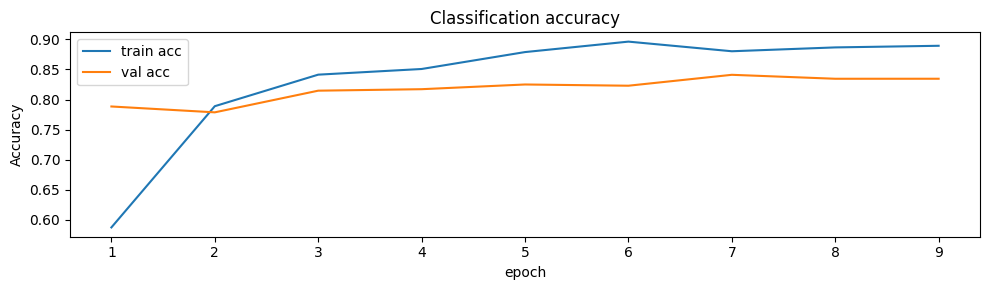

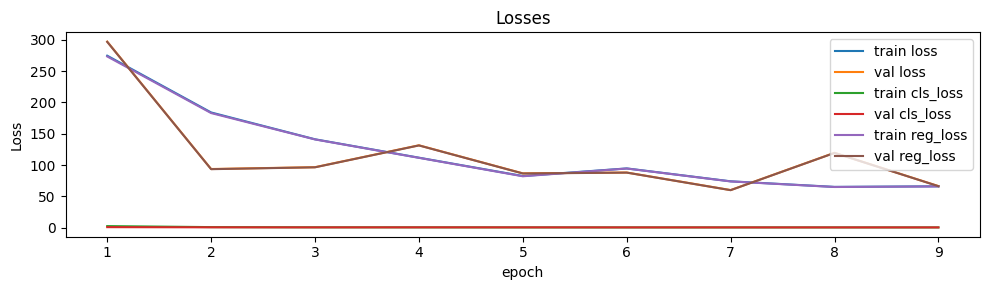

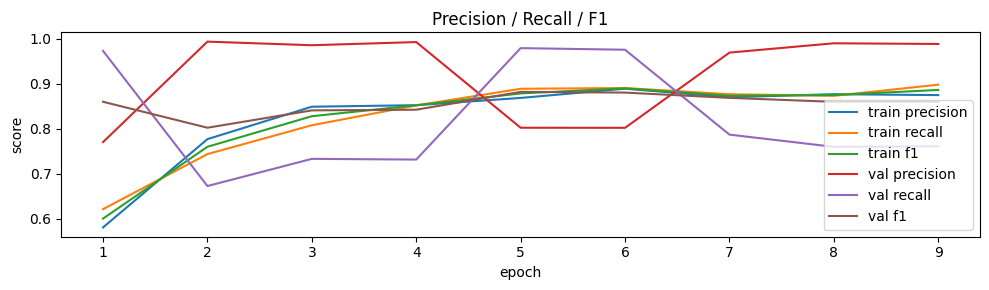

In [23]:
# === Hybrid model evaluation: separate metrics, best-threshold, epoch curves, energy plot ===
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, precision_recall_curve

# -------- helpers --------
def _safe_hist_df(history_obj):
    try:
        import pandas as pd
        log = pd.DataFrame(history_obj.history)
        log.index = np.arange(1, len(log)+1)
        return log
    except Exception:
        return None

def _existing(files):
    return [p for p in files if tf.io.gfile.exists(p)]

def _y_dict_get(d, key):
    if isinstance(d, dict):
        if key in d: return d[key]
        # in rare cases keys can be bytes
        for k, v in d.items():
            if isinstance(k, bytes) and k.decode() == key:
                return v
    raise KeyError(f"Key '{key}' not found in label dict: {list(d.keys())}")

def _collect_cls_probs(ds, max_steps=120):
    ys, ps = [], []
    it = iter(ds)
    for _ in range(max_steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            break
        out = model.predict(xb, verbose=0)
        p   = out["cls"] if isinstance(out, dict) else out  # dict output per our model
        ys.append(_y_dict_get(yb, "cls").numpy().reshape(-1))
        ps.append(np.asarray(p).reshape(-1))
    if not ys:
        return np.array([], np.float32), np.array([], np.float32)
    return np.concatenate(ys), np.concatenate(ps)


def best_threshold_from_val(val_ds, max_steps=60, grid_points=201):
    y_true, y_prob = _collect_cls_probs(val_ds, max_steps=max_steps)
    if y_true.size == 0:
        print("[warn] no validation samples to choose threshold; using 0.50")
        return 0.50, (np.nan, np.nan, np.nan)
    lo, hi = float(np.min(y_prob)), float(np.max(y_prob))
    lo = max(0.0, min(0.5, lo)); hi = min(1.0, max(0.5, hi))
    ts = np.linspace(lo, hi, grid_points, dtype=np.float32)
    best_f1, best_t, best_p, best_r = -1.0, 0.5, np.nan, np.nan
    for t in ts:
        y_hat = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_hat==1) & (y_true==1))
        fp = np.sum((y_hat==1) & (y_true==0))
        fn = np.sum((y_hat==0) & (y_true==1))
        p  = tp / (tp + fp + 1e-8)
        r  = tp / (tp + fn + 1e-8)
        f1 = 2*p*r/(p+r+1e-8)
        if f1 > best_f1:
            best_f1, best_t, best_p, best_r = f1, float(t), float(p), float(r)
    return best_t, (best_p, best_r, best_f1)

# -------- Print separate test metrics from model.evaluate --------
test_steps_cap = min(len(_existing(test_files)), 80)
eval_vals = model.evaluate(test_ds_h, steps=test_steps_cap, verbose=0)
name_to_val = dict(zip(model.metrics_names, eval_vals))

cls_keys  = [k for k in name_to_val if k.startswith("cls_")]
loss_keys = [k for k in name_to_val if k.endswith("loss")]  # loss, reg_loss, cls_loss

print("\n== Test metrics (from model.evaluate) ==")
print("Classification:", {k: round(float(name_to_val[k]), 4) for k in sorted(cls_keys)})
print("Losses:",        {k: round(float(name_to_val[k]), 4) for k in sorted(loss_keys)})

# -------- Best threshold on validation (max F1) + re-score on test --------
best_t, (p_v, r_v, f1_v) = best_threshold_from_val(val_ds_h, max_steps=60)
print(f"\n[val] Best threshold = {best_t:.3f}  (precision={p_v:.3f}, recall={r_v:.3f}, f1={f1_v:.3f})")

y_true, y_prob = _collect_cls_probs(test_ds_h, max_steps=120)
if y_true.size:
    y_hat = (y_prob >= best_t).astype(np.float32)
    tp = np.sum((y_hat==1) & (y_true==1))
    fp = np.sum((y_hat==1) & (y_true==0))
    fn = np.sum((y_hat==0) & (y_true==1))
    acc = (y_hat == y_true).mean()
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2*prec*rec/(prec+rec+1e-8)
    print(f"[test @ t={best_t:.3f}] acc={acc:.3f}  precision={prec:.3f}  recall={rec:.3f}  f1={f1:.3f}\n")

    # Classification report
    print("Classification report (test):\n",
          classification_report(y_true, y_hat,
                                target_names=["non-event","event"], digits=3))

else:
    print("[warn] No samples collected from test set for threshold-based scoring.")

# -------- Epoch curves (accuracy/loss first; then precision/recall/F1; optional reg loss) --------
if 'history' in globals() and hasattr(history, 'history'):
    log = _safe_hist_df(history)
    if log is not None:
        try:
            from IPython.display import display
            display(log)
        except Exception:
            print(log.tail())

        # Accuracy (cls) first
        plt.figure(figsize=(10,3))
        if "cls_accuracy" in log:     plt.plot(log["cls_accuracy"],     label="train acc")
        if "val_cls_accuracy" in log: plt.plot(log["val_cls_accuracy"], label="val acc")
        plt.xlabel("epoch"); plt.ylabel("Accuracy"); plt.title("Classification accuracy"); plt.legend()
        plt.tight_layout(); plt.show()

        # Loss next (total + cls + (optional reg))
        plt.figure(figsize=(10,3))
        if "loss" in log:         plt.plot(log["loss"],         label="train loss")
        if "val_loss" in log:     plt.plot(log["val_loss"],     label="val loss")
        if "cls_loss" in log:     plt.plot(log["cls_loss"],     label="train cls_loss")
        if "val_cls_loss" in log: plt.plot(log["val_cls_loss"], label="val cls_loss")
        if "reg_loss" in log:     plt.plot(log["reg_loss"],     label="train reg_loss")
        if "val_reg_loss" in log: plt.plot(log["val_reg_loss"], label="val reg_loss")
        plt.xlabel("epoch"); plt.ylabel("Loss"); plt.title("Losses"); plt.legend()
        plt.tight_layout(); plt.show()

        # Precision / Recall / F1 curves
        plt.figure(figsize=(10,3))
        for k, lbl in [("precision","train precision"), ("recall","train recall"), ("f1","train f1")]:
            kk = f"cls_{k}"
            if kk in log: plt.plot(log[kk], label=lbl)
        for k, lbl in [("precision","val precision"), ("recall","val recall"), ("f1","val f1")]:
            kk = f"val_cls_{k}"
            if kk in log: plt.plot(log[kk], label=lbl)
        plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Precision / Recall / F1"); plt.legend()
        plt.tight_layout(); plt.show()




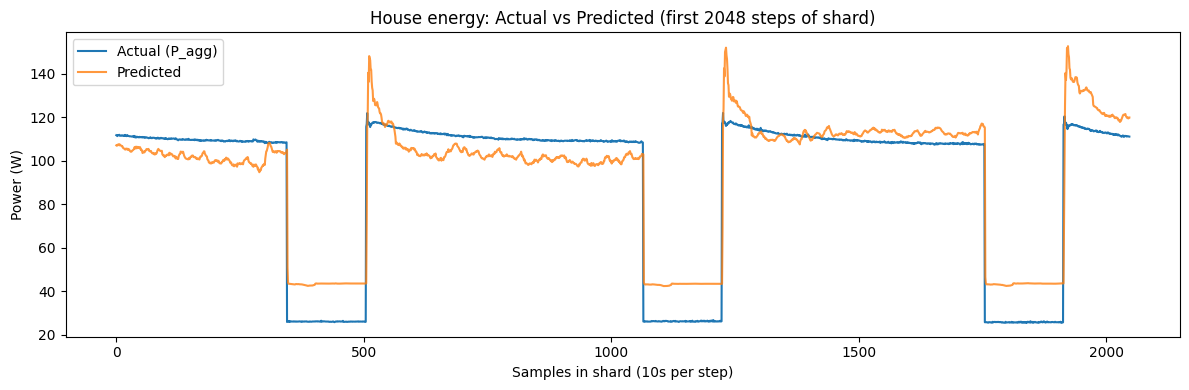

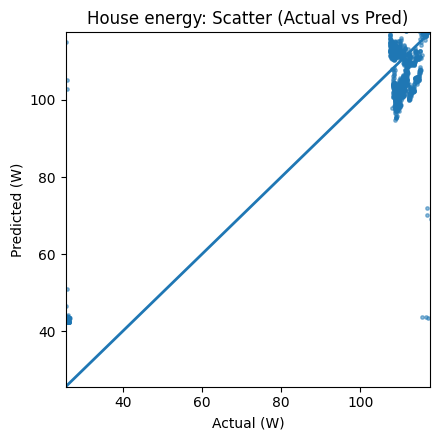

In [15]:
# === Actual vs Predicted Energy (time-series + scatter) ===
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from pathlib import Path

# --- helpers: file existence + robust NPZ reader for continuous targets ---
def _existing(files):
    return [p for p in files if tf.io.gfile.exists(p)]

def _to_path_str(x):
    if hasattr(x, "numpy"): x = x.numpy()
    if isinstance(x, (bytes, np.bytes_)): return x.decode("utf-8")
    if isinstance(x, np.ndarray) and x.shape == (): x = x.item()
    return str(x)

def _read_npz_reg(path_tensor):
    p = _to_path_str(path_tensor)
    with np.load(p, allow_pickle=False, mmap_mode="r") as d:
        X = np.asarray(d["X"], dtype=np.float32)           # (B, T, F)
        y = d["y"]                                         # (B,) or (B,H)
        y = y if y.ndim == 2 else y[:, None]               # -> (B, H)
    return X, y.astype(np.float32, copy=False)

def _map_read_reg(path):
    X, y = tf.numpy_function(_read_npz_reg, [path], Tout=[tf.float32, tf.float32])
    X.set_shape([None, LOOKBACK, N_FEATS])
    y.set_shape([None, HORIZON])
    return X, y

def make_reg_eval_dataset(files, max_shards=2, deterministic=True):
    files = _existing(files)[:max_shards]
    if not files:
        empty = (tf.zeros([0, LOOKBACK, N_FEATS], tf.float32),
                 tf.zeros([0, HORIZON], tf.float32))
        return tf.data.Dataset.from_tensors(empty)
    ds = tf.data.Dataset.from_tensor_slices(files)
    ds = ds.map(_map_read_reg, num_parallel_calls=tf.data.AUTOTUNE, deterministic=deterministic)
    # keep shard-batch as-is (each element is a full shard batch)
    return ds.prefetch(tf.data.AUTOTUNE).with_options(
        tf.data.Options()  # will default to deterministic in TF2.12+
    )

# --- extract regression predictions from hybrid model output safely ---
def _extract_regression(pred):
    """
    Accepts model.predict(...) output in {dict, list/tuple, tensor}
    Returns (B, H) regression array or None if not found.
    """
    if isinstance(pred, dict):
        if "reg" in pred: return np.array(pred["reg"])
        # if keys unknown, try first value that looks (B,H)
        for v in pred.values():
            v = np.array(v)
            if v.ndim == 2 and v.shape[-1] == HORIZON: return v
        return None
    if isinstance(pred, (list, tuple)):
        # assume first is regression if shaped (B,H)
        for v in pred:
            v = np.array(v)
            if v.ndim == 2 and v.shape[-1] == HORIZON: return v
        return None
    # single tensor/array
    arr = np.array(pred)
    if arr.ndim == 2 and arr.shape[-1] == HORIZON:
        return arr
    return None

# --- plot function ---
def plot_actual_vs_predicted_energy(model, shard_files, max_shards=1, title_prefix="Energy"):
    ds = make_reg_eval_dataset(shard_files, max_shards=max_shards, deterministic=True)
    it = iter(ds)
    try:
        Xb, yb = next(it)  # one shard batch
    except StopIteration:
        print("No evaluation shards available.")
        return

    pred = model.predict(Xb, verbose=0)
    y_pred = _extract_regression(pred)
    if y_pred is None:
        print("Current model does not expose a regression head; energy plot skipped.")
        return

    y_true = yb.numpy()               # (B, H)
    y_true = y_true.reshape(-1)       # flatten for HORIZON=1 (or contiguous for H>1)
    y_pred = y_pred.reshape(-1)

    n = min(len(y_true), 3000)        # limit for quick plotting
    x = np.arange(n)

    # Time-series overlay
    plt.figure(figsize=(12,4))
    plt.plot(x, y_true[:n], label="Actual (P_agg)")
    plt.plot(x, y_pred[:n], label="Predicted", alpha=0.8)
    plt.title(f"{title_prefix}: Actual vs Predicted (first {n} steps of shard)")
    plt.xlabel("Samples in shard (10s per step)"); plt.ylabel("Power (W)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Scatter: calibration view
    lim_lo = np.percentile(y_true[:n], 1)
    lim_hi = np.percentile(y_true[:n], 99)
    lo, hi = float(lim_lo), float(lim_hi)
    grid = np.linspace(lo, hi, 100)

    plt.figure(figsize=(4.5,4.5))
    plt.scatter(y_true[:n], y_pred[:n], s=6, alpha=0.5)
    plt.plot(grid, grid, linewidth=2)
    plt.title(f"{title_prefix}: Scatter (Actual vs Pred)")
    plt.xlabel("Actual (W)"); plt.ylabel("Predicted (W)")
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.tight_layout(); plt.show()

# --- call on your test shards ---
plot_actual_vs_predicted_energy(model, test_files, max_shards=1, title_prefix="House energy")


In [24]:
# === MC Dropout for hybrid classifier (FIXED: uses cls labels, auto-threshold) ===
import numpy as np, tensorflow as tf

def _pick_cls_tensor(obj):
    """Return a (B,1) classification-prob tensor from model output or raise."""
    if isinstance(obj, dict):
        if "cls" in obj:
            v = tf.convert_to_tensor(obj["cls"])
            return tf.ensure_shape(v, [None, 1])
        # fallback: find any (B,1)
        for v in obj.values():
            v = tf.convert_to_tensor(v)
            if v.shape.rank == 2 and v.shape[-1] == 1:
                return tf.ensure_shape(v, [None, 1])
        raise ValueError("No (B,1) classification head found in dict output.")
    if isinstance(obj, (list, tuple)):
        for v in obj:
            v = tf.convert_to_tensor(v)
            if v.shape.rank == 2 and v.shape[-1] == 1:
                return tf.ensure_shape(v, [None, 1])
        raise ValueError("No (B,1) classification head found in list/tuple output.")
    v = tf.convert_to_tensor(obj)
    if v.shape.rank == 2 and v.shape[-1] == 1:
        return tf.ensure_shape(v, [None, 1])
    raise ValueError("Model output is not (B,1) probs.")

def _pick_cls_labels(y):
    """Return a 1D float array of {0,1} labels from hybrid dataset labels."""
    if isinstance(y, dict):
        if "cls" in y:
            v = tf.convert_to_tensor(y["cls"])
        else:
            v = None
            for val in y.values():
                t = tf.convert_to_tensor(val)
                if t.shape.rank == 2 and t.shape[-1] == 1:
                    v = t; break
            if v is None:
                raise ValueError("No (B,1) classification label found in label dict.")
    else:
        v = tf.convert_to_tensor(y)  # try best-effort
    v = tf.cast(tf.reshape(v, [-1]), tf.float32).numpy()
    # ensure binary; if not, binarize at 0.5 (safety net)
    u = np.unique(v)
    if not np.all(np.isin(u, [0.0, 1.0])):
        v = (v >= 0.5).astype(np.float32)
    return v

def _collect_cls_probs(ds, max_batches=60, training=False):
    ys, ps = [], []
    it = iter(ds)
    for _ in range(max_batches):
        try:
            xb, yb = next(it)
        except StopIteration:
            break
        probs = _pick_cls_tensor(model(xb, training=training)).numpy().reshape(-1)
        ytrue = _pick_cls_labels(yb)
        ys.append(ytrue); ps.append(probs)
    if not ys:
        return np.array([], np.float32), np.array([], np.float32)
    return np.concatenate(ys), np.concatenate(ps)

def _metrics(y_true01, y_prob, t):
    y_hat = (y_prob >= t).astype(np.float32)
    acc = (y_hat == y_true01).mean()
    tp  = np.sum((y_hat==1) & (y_true01==1))
    fp  = np.sum((y_hat==1) & (y_true01==0))
    fn  = np.sum((y_hat==0) & (y_true01==1))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2*prec*rec / (prec + rec + 1e-8)
    return acc, prec, rec, f1

def best_threshold_from_val(val_ds_h, max_batches=60, grid_points=201):
    y_true, y_prob = _collect_cls_probs(val_ds_h, max_batches=max_batches, training=False)
    if y_true.size == 0:
        print("[warn] empty validation set; using t=0.50")
        return 0.50
    lo, hi = float(np.min(y_prob)), float(np.max(y_prob))
    lo = max(0.0, min(0.5, lo)); hi = min(1.0, max(0.5, hi))
    ts = np.linspace(lo, hi, grid_points, dtype=np.float32)
    best_f1, best_t = -1.0, 0.5
    for t in ts:
        _, _, _, f1 = _metrics(y_true, y_prob, t)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    pos_rate = float(y_true.mean())
    print(f"[val] pos_rate={pos_rate:.3f}  prob[min/mean/max]={y_prob.min():.3f}/{y_prob.mean():.3f}/{y_prob.max():.3f}")
    print(f"[val] best_t={best_t:.3f} (max F1={best_f1:.3f})")
    return best_t

def mc_dropout_eval(val_ds_h, test_ds_h, mc_passes=20, val_steps=60, test_steps=120, threshold=None):
    # threshold from validation if not provided
    t = best_threshold_from_val(val_ds_h, max_batches=val_steps) if threshold is None else float(threshold)

    # Single-pass test (no MC)
    y_true_sp, y_prob_sp = _collect_cls_probs(test_ds_h, max_batches=test_steps, training=False)
    if y_true_sp.size == 0:
        print("[error] empty test set.")
        return
    print(f"[test-single] pos_rate={y_true_sp.mean():.3f}  prob[min/mean/max]={y_prob_sp.min():.3f}/{y_prob_sp.mean():.3f}/{y_prob_sp.max():.3f}")
    acc, prec, rec, f1 = _metrics(y_true_sp, y_prob_sp, t)
    print(f"[test-single @ t={t:.3f}] acc={acc:.3f}  precision={prec:.3f}  recall={rec:.3f}  f1={f1:.3f}")

    # MC-DO mean probs on test
    ys, mus, sigs = [], [], []
    it = iter(test_ds_h)
    for _ in range(min(test_steps, 10)):
        try:
            xb, yb = next(it)
        except StopIteration:
            break
        mean = None; M2 = None; n = 0
        for _ in range(mc_passes):
            p = _pick_cls_tensor(model(xb, training=True)).numpy()  # (B,1)
            if mean is None:
                mean = np.zeros_like(p, dtype=np.float64)
                M2   = np.zeros_like(p, dtype=np.float64)
            n += 1
            d  = p - mean
            mean += d / n
            M2   += d * (p - mean)
        var = M2 / max(1, n-1)
        ys.append(_pick_cls_labels(yb))
        mus.append(mean.astype(np.float32).reshape(-1))
        sigs.append(np.sqrt(var).astype(np.float32).reshape(-1))
    y_true_mc = np.concatenate(ys, axis=0)
    y_mu_mc   = np.concatenate(mus, axis=0)
    y_std_mc  = np.concatenate(sigs, axis=0)
    acc, prec, rec, f1 = _metrics(y_true_mc, y_mu_mc, t)
    print(f"[test-MC  @ t={t:.3f}] acc={acc:.3f}  precision={prec:.3f}  recall={rec:.3f}  f1={f1:.3f}  mean σ={y_std_mc.mean():.3f}")

# --- Run  ---
mc_dropout_eval(val_ds_h, test_ds_h, mc_passes=20, val_steps=60, test_steps=120, threshold=None)


[val] pos_rate=0.739  prob[min/mean/max]=0.008/0.807/1.000
[val] best_t=0.851 (max F1=0.922)
[test-single] pos_rate=0.768  prob[min/mean/max]=0.007/0.785/1.000
[test-single @ t=0.851] acc=0.881  precision=0.936  recall=0.908  f1=0.922
[test-MC  @ t=0.851] acc=0.686  precision=0.836  recall=0.080  f1=0.146  mean σ=0.215


In [35]:
# === Federated classification (per-house) — PURE TF FedAvg, no Flower (robust metrics) ===
import os, json, random, numpy as np, tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers as L, models as M, regularizers as R

# ------------------ CPU only ------------------
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "-1")
try:
    tf.config.set_visible_devices([], "CPU")
except Exception:
    pass

# ------------------ IO / shapes ------------------
META_DIR = Path("/content/plegma_final/meta")
with open(META_DIR / "final_manifest.json") as f: MANI = json.load(f)
with open(META_DIR / "features.json")       as f: FEATURES = json.load(f)

def _scalar_int(x, name):
    if isinstance(x, (int, np.integer)): return int(x)
    if isinstance(x, float):             return int(round(x))
    if isinstance(x, str):
        try: return int(float(x))
        except Exception: pass
    if isinstance(x, (list, tuple)) and len(x) == 1:
        return _scalar_int(x[0], name)
    raise TypeError(f"{name} must be a scalar integer, got {x!r} (type={type(x).__name__})")

LOOKBACK = _scalar_int(MANI.get("lookback"), "lookback")
HORIZON  = _scalar_int(MANI.get("horizon"),  "horizon")

if isinstance(FEATURES, (list, tuple)):
    N_FEATS = int(len(FEATURES))
else:
    tr = MANI["splits"]["train"]
    first_npz = next((p for p in tr if tf.io.gfile.exists(p)), None)
    if first_npz is None: raise RuntimeError("No existing train shard to infer features.")
    with np.load(first_npz, allow_pickle=False, mmap_mode="r") as d:
        X0 = np.asarray(d["X"])
        if X0.ndim != 3: raise RuntimeError(f"Bad X shape {X0.shape}, expected (B,T,F).")
        N_FEATS = int(X0.shape[-1])
    FEATURES = [f"f{i}" for i in range(N_FEATS)]

if LOOKBACK <= 0 or HORIZON <= 0 or N_FEATS <= 0:
    raise ValueError(f"Invalid shapes -> LOOKBACK={LOOKBACK} HORIZON={HORIZON} N_FEATS={N_FEATS}")

print(f"[shapes] lookback={LOOKBACK}  horizon={HORIZON}  n_feats={N_FEATS}")

TRAIN_FILES = list(MANI["splits"]["train"])
VAL_FILES   = list(MANI["splits"]["val"])

# Optional shard counts for weighting
PATH2COUNT = {rec["path"]: int(rec["n_samples"])
              for split in ("train","val","test")
              for rec in MANI.get("shards_meta", {}).get(split, [])}

# ------------------ utils ------------------
def _existing(files): return [p for p in files if tf.io.gfile.exists(p)]

def _count_examples(files):
    tot = 0
    for p in files:
        if p in PATH2COUNT:
            tot += PATH2COUNT[p]
        else:
            try:
                with np.load(p, allow_pickle=False, mmap_mode="r") as d:
                    tot += int(d["y"].shape[0])
            except Exception:
                pass
    return tot

def _to_path_str(x):
    if hasattr(x, "numpy"): x = x.numpy()
    if isinstance(x, (bytes, np.bytes_)): return x.decode("utf-8")
    if isinstance(x, np.ndarray) and x.shape == (): x = x.item()
    return str(x)

def _read_npz_batched(path_tensor):
    p = _to_path_str(path_tensor)
    with np.load(p, allow_pickle=False, mmap_mode="r") as d:
        X = np.asarray(d["X"], dtype=np.float32)           # (B,T,F)
        y = d["y"]; y = y if y.ndim == 2 else y[:, None]   # (B,H)
    return X, y

def _map_read_batched(path):
    X, y = tf.numpy_function(_read_npz_batched, [path], Tout=[tf.float32, tf.float32])
    X.set_shape([None, LOOKBACK, N_FEATS])
    y.set_shape([None, HORIZON])
    return X, y

# ------------------ global event threshold ------------------
def estimate_threshold(files, quantile=0.50, max_shards=100, max_points=2_000_000, seed=13):
    rng = random.Random(seed); files = _existing(files)
    if not files: return 0.0
    sample = rng.sample(files, k=min(len(files), max_shards))
    buf, total = [], 0
    for p in sample:
        try:
            with np.load(p, allow_pickle=False, mmap_mode="r") as d:
                y = d["y"]; y = y if y.ndim == 2 else y[:, None]
                y = y.reshape(-1)
                need = max_points - total
                if need <= 0: break
                take = y[:need] if y.size > need else y
                buf.append(np.asarray(take, np.float32)); total += take.size
        except Exception:
            pass
    thr = float(np.percentile(np.concatenate(buf), quantile*100.0)) if buf else 0.0
    print(f"[threshold] {quantile:.0%} percentile -> {thr:.3f} W")
    return thr

THRESHOLD = estimate_threshold(TRAIN_FILES, quantile=0.50)

# ------------------ per-house mapping ------------------
def _house_id_from_name(p: str) -> int:
    try: return int(Path(p).name.split("-")[0][1:])
    except Exception: return -1

def files_for_house(split: str, hid: int):
    return [p for p in MANI["splits"][split] if Path(p).name.startswith(f"H{hid}-{split}-")]

# ------------------ binary dataset (shard-batched) ------------------
def files_to_binary_dataset(files, threshold, rule="any",
                            shuffle=True, repeat=True, deterministic=False):
    files = _existing(files)
    if not files:
        empty = (tf.zeros([0, LOOKBACK, N_FEATS], tf.float32),
                 tf.zeros([0, 1], tf.float32))
        return tf.data.Dataset.from_tensors(empty)

    th = tf.constant(threshold, tf.float32)

    def to_binary(X, y):
        if HORIZON > 1:
            y_cont = tf.reduce_max(y, axis=1, keepdims=True) if rule == "any" else y[:, -1:, ...]
        else:
            y_cont = y
        yb = tf.cast(y_cont >= th, tf.float32)
        return X, yb

    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle and len(files) > 1:
        ds = ds.shuffle(len(files), reshuffle_each_iteration=True)
    ds = ds.map(_map_read_batched, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(to_binary,       num_parallel_calls=tf.data.AUTOTUNE)
    if repeat:
        ds = ds.repeat()

    opts = tf.data.Options()
    try:
        opts.experimental_deterministic = bool(deterministic)
    except Exception:
        pass
    ds = ds.with_options(opts)
    return ds.prefetch(tf.data.AUTOTUNE)

# ------------------ simple attention + classifier ------------------
def tiny_self_attention(x, wd=1e-5, name="attn"):
    s = L.Dense(1, kernel_regularizer=R.l2(wd), name=f"{name}_score")(x)   # (B,T,1)
    w = L.Softmax(axis=1, name=f"{name}_softmax")(s)                        # (B,T,1)
    ctx = L.Multiply(name=f"{name}_mul")([x, w])                            # (B,T,H)
    ctx = L.Lambda(lambda t: tf.reduce_sum(t, axis=1), name=f"{name}_sum")(ctx)  # (B,H)
    return ctx

def _sepconv_block_ln(x, f, k=5, d=1, pool=2, drop=0.15, wd=1e-5, name=None):
    sc = x
    x = L.SeparableConv1D(f, k, padding="same", dilation_rate=d,
                          depthwise_regularizer=R.l2(wd), pointwise_regularizer=R.l2(wd),
                          name=None if name is None else f"{name}_sc1")(x)
    x = L.LayerNormalization(name=None if name is None else f"{name}_ln1")(x)
    x = L.Activation("relu")(x)
    x = L.SeparableConv1D(f, k, padding="same", dilation_rate=d,
                          depthwise_regularizer=R.l2(wd), pointwise_regularizer=R.l2(wd),
                          name=None if name is None else f"{name}_sc2")(x)
    x = L.LayerNormalization(name=None if name is None else f"{name}_ln2")(x)
    if sc.shape[-1] != f:
        sc = L.Conv1D(f, 1, padding="same", kernel_regularizer=R.l2(wd),
                      name=None if name is None else f"{name}_proj")(sc)
    x = L.Add()([x, sc]); x = L.Activation("relu")(x); x = L.SpatialDropout1D(drop)(x)
    if pool and pool > 1: x = L.MaxPool1D(pool)(x)
    return x

def build_classifier(lookback, n_features,
                     conv=((32,7,1,2),(64,5,2,2),(64,3,4,1)),
                     gru_units=64, drop=0.2, wd=1e-5):
    inp = L.Input(shape=(int(lookback), int(n_features)), name="inp")
    x = inp
    for i,(f,k,d,p) in enumerate(conv):
        x = _sepconv_block_ln(x, f, k=k, d=d, pool=p, drop=drop, wd=wd, name=f"blk{i+1}")
    x = L.GRU(gru_units, return_sequences=True, name="gru")(x)
    x = L.Dropout(drop)(x)
    ctx  = tiny_self_attention(x, wd=wd, name="sattn")           # (B,H)
    last = L.Lambda(lambda t: t[:, -1, :], name="last_t")(x)     # (B,H)
    h = L.Concatenate(name="fuse")([ctx, last])                  # (B,2H)
    h = L.Dense(96, activation="relu", kernel_regularizer=R.l2(wd))(h); h = L.Dropout(drop)(h)
    h = L.Dense(64, activation="relu", kernel_regularizer=R.l2(wd))(h); h = L.Dropout(drop)(h)
    out = L.Dense(1, activation="sigmoid", name="y_prob")(h)
    return M.Model(inp, out, name="energy_event_classifier_cpu")

def make_optimizer(lr=2e-3, wd=1e-5, clipnorm=1.0):
    try: return tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd, clipnorm=clipnorm)
    except Exception: return tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)

def clone_compiled():
    model = build_classifier(LOOKBACK, N_FEATS)
    opt = make_optimizer(lr=2e-3, wd=1e-5, clipnorm=1.0)
    # We keep metrics if you want to see them during local fit, but we DO NOT rely on them later.
    model.compile(optimizer=opt, loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)])
    return model

# ------------------ per-house datasets ------------------
def make_house_datasets(hid: int, rule="any"):
    tr_files = files_for_house("train", hid)
    va_files = files_for_house("val",   hid)
    if not tr_files:
        return None, None, 0, 0, 0, 0
    ds_tr = files_to_binary_dataset(tr_files, THRESHOLD, rule=rule, shuffle=True,  repeat=True,  deterministic=False)
    ds_va = files_to_binary_dataset(va_files, THRESHOLD, rule=rule, shuffle=False, repeat=False, deterministic=True)
    tr_steps = len(_existing(tr_files))
    va_steps = len(_existing(va_files)) if va_files else 0
    tr_n = _count_examples(tr_files); va_n = _count_examples(va_files) if va_files else 0
    return ds_tr, ds_va, tr_steps, va_steps, tr_n, va_n

def _avg_shard_size(files):
    if not files: return 0
    sizes = []
    for p in files:
        if p in PATH2COUNT: sizes.append(PATH2COUNT[p])
        else:
            try:
                with np.load(p, allow_pickle=False, mmap_mode="r") as d:
                    sizes.append(int(d["y"].shape[0]))
            except Exception: pass
    return int(np.mean(sizes)) if sizes else 0

# ------------------ manual classification metrics ------------------
def _get_cls_probs(mout):
    if isinstance(mout, dict):
        if "y_prob" in mout: v = mout["y_prob"]
        else: raise ValueError("Expected dict output with key 'y_prob'.")
    else:
        v = mout
    v = tf.convert_to_tensor(v)
    if v.shape.rank == 2 and v.shape[-1] == 1:
        return tf.squeeze(v, axis=-1)  # (B,)
    raise ValueError(f"Unexpected model output shape {v.shape}; need (B,1).")

def eval_cls_manual(model, dataset, max_steps, threshold=0.5):
    """Return (acc, prec, rec, f1, n_examples) computed from probs."""
    it = iter(dataset)
    TP = FP = FN = TN = 0
    n_total = 0
    for _ in range(max_steps):
        try:
            xb, yb = next(it)             # yb: (B,1) binary labels from dataset
        except StopIteration:
            break
        probs = _get_cls_probs(model(xb, training=False)).numpy()  # (B,)
        y_true = tf.reshape(yb, [-1]).numpy().astype(np.float32)   # (B,)
        y_hat  = (probs >= threshold).astype(np.float32)
        TP += int(np.sum((y_hat == 1) & (y_true == 1)))
        FP += int(np.sum((y_hat == 1) & (y_true == 0)))
        FN += int(np.sum((y_hat == 0) & (y_true == 1)))
        TN += int(np.sum((y_hat == 0) & (y_true == 0)))
        n_total += y_true.size
    if n_total == 0:
        return 0.0, 0.0, 0.0, 0.0, 0
    acc = (TP + TN) / max(1, n_total)
    prec = TP / max(1, TP + FP)
    rec  = TP / max(1, TP + FN)
    f1   = (2 * prec * rec) / max(1e-8, (prec + rec))
    return float(acc), float(prec), float(rec), float(f1), n_total

# ------------------ FedAvg utils ------------------
def weighted_avg_weights(weights_list, counts):
    if not weights_list: return None
    total = float(sum(counts)) or 1.0
    coef = [c/total for c in counts]
    avg = []
    for layer_tuples in zip(*weights_list):
        stacked = np.stack([w for w in layer_tuples], axis=0)
        avg.append(np.tensordot(coef, stacked, axes=[0,0]))
    return avg

# ------------------ Select clients ------------------
houses = sorted({_house_id_from_name(p) for p in TRAIN_FILES if _house_id_from_name(p) >= 0})
if not houses: raise RuntimeError("No federated clients found.")
print("Clients (houses):", houses)

# ------------------ Build datasets once ------------------
per_house = {}
for hid in houses:
    ds_tr, ds_va, tr_steps, va_steps, tr_n, va_n = make_house_datasets(hid, rule="any")
    per_house[hid] = dict(
        ds_tr=ds_tr, ds_va=ds_va,
        tr_steps=tr_steps, va_steps=va_steps,
        tr_n=tr_n, va_n=va_n,
        avg_tr_shard=_avg_shard_size(files_for_house("train", hid)),
        avg_va_shard=_avg_shard_size(files_for_house("val",   hid)),
    )

# ------------------ Federated training loop ------------------
ROUNDS = 3
LOCAL_EPOCHS = 1
STEPS_PER_EPOCH = 50
VAL_STEPS = 10
DECISION_THRESHOLD = 0.5  # use your tuned/best threshold if you have one

global_model = clone_compiled()
global_weights = global_model.get_weights()

for rnd in range(1, ROUNDS+1):
    print(f"\n=== Round {rnd}/{ROUNDS} ===")
    client_weights, client_counts = [], []

    # local training on each client
    for hid in houses:
        info = per_house[hid]
        if info["ds_tr"] is None or info["tr_steps"] == 0:
            continue
        m = clone_compiled()
        m.set_weights(global_weights)
        steps = min(info["tr_steps"], STEPS_PER_EPOCH)
        m.fit(info["ds_tr"], epochs=LOCAL_EPOCHS, steps_per_epoch=steps, verbose=0)
        # count seen samples approximately by shard size (ok for FedAvg weighting)
        seen = steps * max(1, info["avg_tr_shard"])
        client_weights.append(m.get_weights())
        client_counts.append(seen)

    if not client_weights:
        print("[warn] No client updates this round; skipping aggregation.")
        continue

    # aggregate
    global_weights = weighted_avg_weights(client_weights, client_counts)
    global_model.set_weights(global_weights)

    # manual weighted validation across clients
    tot_examples = 0
    sum_acc = sum_pre = sum_rec = sum_f1 = 0.0
    for hid in houses:
        info = per_house[hid]
        if info["ds_va"] is None or info["va_steps"] == 0:
            continue
        steps = min(info["va_steps"], VAL_STEPS)
        acc, pre, rec, f1, n = eval_cls_manual(global_model, info["ds_va"], steps, threshold=DECISION_THRESHOLD)
        sum_acc += acc * n; sum_pre += pre * n; sum_rec += rec * n; sum_f1 += f1 * n
        tot_examples += n
    if tot_examples > 0:
        print(f"[Round {rnd}] val (weighted): "
              f"acc={sum_acc/tot_examples:.3f}  "
              f"prec={sum_pre/tot_examples:.3f}  "
              f"recall={sum_rec/tot_examples:.3f}  "
              f"f1={sum_f1/tot_examples:.3f}")
    else:
        print(f"[Round {rnd}] no validation data available.")

print("\n[Done] Global model ready — trained via pure-TF FedAvg (manual metrics, no metrics_names dependency).")


[shapes] lookback=60  horizon=1  n_feats=31
[threshold] 50% percentile -> 106.246 W
Clients (houses): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

=== Round 1/3 ===
[Round 1] val (weighted): acc=0.804  prec=0.864  recall=0.826  f1=0.835

=== Round 2/3 ===
[Round 2] val (weighted): acc=0.850  prec=0.869  recall=0.899  f1=0.876

=== Round 3/3 ===
[Round 3] val (weighted): acc=0.903  prec=0.946  recall=0.893  f1=0.915

[Done] Global model ready — trained via pure-TF FedAvg (manual metrics, no metrics_names dependency).
